# CREDIT DEFAULT RISK PREDICTION 

In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency, shapiro, mannwhitneyu
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import shap
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import warnings
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


## Dataset Summary

(307511, 146)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 146 entries, TARGET to inst_SK_ID_PREV_count
dtypes: float64(129), int64(1), object(16)
memory usage: 342.5+ MB


None


Target class balance:


,TARGET,Proportion
0,0,0.919271
1,1,0.080729


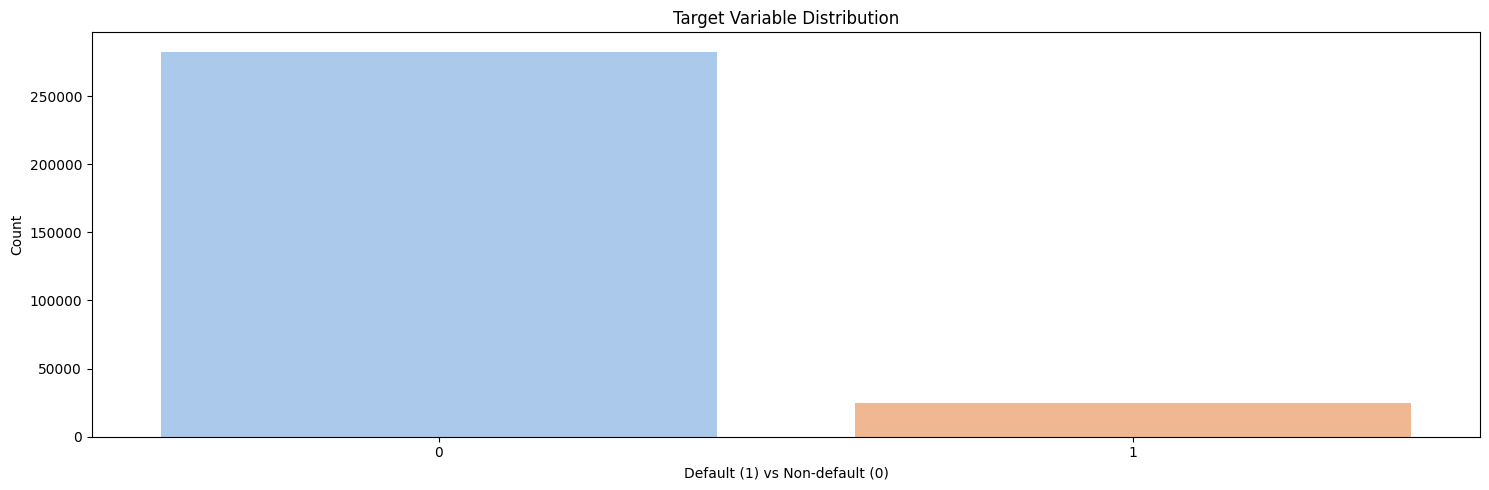

In [3]:
df = pd.read_csv("train_final_compact.csv")

# 1. Basic dataset summary
display(df.shape)
display(df.info())

# 2. Check target distribution
target_counts = df['TARGET'].value_counts(normalize=True).rename_axis("TARGET").reset_index(name='Proportion')
print("\nTarget class balance:")
display(target_counts)

# 3. Plot target distribution
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='TARGET', palette='pastel', hue='TARGET', legend=False)
plt.title('Target Variable Distribution')
plt.xlabel('Default (1) vs Non-default (0)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Missing Values

In [4]:
# Step 1B: Missing Value Summary
missing_df = df.isnull().sum().to_frame(name='MissingCount')
missing_df['MissingRatio'] = missing_df['MissingCount'] / len(df)
missing_df = missing_df[missing_df['MissingCount'] > 0]
missing_df = missing_df.sort_values(by='MissingRatio', ascending=False)

# Display top 20 features with missing values
display(missing_df.head(20))
print(f"\nTotal columns with missing values: {missing_df.shape[0]}")


,MissingCount,MissingRatio
cc_AMT_BALANCE_mean,220606,0.717392
cc_CNT_INSTALMENT_MATURE_CUM_mean,220606,0.717392
cc_AMT_DRAWINGS_CURRENT_mean,220606,0.717392
cc_AMT_DRAWINGS_CURRENT_sum,220606,0.717392
cc_AMT_CREDIT_LIMIT_ACTUAL_mean,220606,0.717392
cc_MONTHS_BALANCE_count,220606,0.717392
cc_MONTHS_BALANCE_max,220606,0.717392
cc_MONTHS_BALANCE_min,220606,0.717392
bureau_STATUS_X_sum,215280,0.700073
bureau_MONTHS_BALANCE_max,215280,0.700073



Total columns with missing values: 46


### Missing Value Summary

In this step, we analyzed the extent of missing data in our final training dataset (`train_final.csv`), which contains 146 features and 307,511 rows.

#### Key Findings:
- **Total columns with missing values**: `46`
- **Columns with critical missingness**:
  - Over 20 features from the **credit card (`cc_`)**, **bureau**, and **POS_CASH_balance** tables have **>70% missing values**.
  - Top missing columns (e.g., `cc_AMT_BALANCE_mean`, `cc_MONTHS_BALANCE_count`, `bureau_STATUS_X_sum`) have missing ratios around `71.7%` and `70.0%`.

#### Interpretation:
- These features were engineered from auxiliary tables. The high missingness likely results from customers **without records in those auxiliary tables**, not from data entry errors.
- For example, a customer with no credit card history will have missing values in all `cc_` features.

#### Implications:
- Columns with very high missingness (≥70%) should be **evaluated for utility**. If they offer little predictive power, consider dropping them.

- For the remaining features:
  - Impute sums/counts with zero (if absence = zero activity),
  
  - Use domain logic or median for continuous fields.


---


### Categorical Feature Summary

In [5]:
# Step 1C(a): Summary of categorical features
cat_cols = df.select_dtypes(include='object').columns.tolist()

print(f"Total categorical features: {len(cat_cols)}")

# Show value counts for each categorical column
for col in cat_cols:
    print(f"\n▶ Column: {col}")
    print(df[col].value_counts(dropna=False, normalize=True).head(10))
    print("-" * 40)


Total categorical features: 16

▶ Column: NAME_CONTRACT_TYPE
NAME_CONTRACT_TYPE
Cash loans         0.904787
Revolving loans    0.095213
Name: proportion, dtype: float64
----------------------------------------

▶ Column: CODE_GENDER
CODE_GENDER
F      0.658344
M      0.341643
XNA    0.000013
Name: proportion, dtype: float64
----------------------------------------

▶ Column: FLAG_OWN_CAR
FLAG_OWN_CAR
N    0.659892
Y    0.340108
Name: proportion, dtype: float64
----------------------------------------

▶ Column: FLAG_OWN_REALTY
FLAG_OWN_REALTY
Y    0.693673
N    0.306327
Name: proportion, dtype: float64
----------------------------------------

▶ Column: NAME_TYPE_SUITE
NAME_TYPE_SUITE
Unaccompanied      0.808186
Family             0.130561
Spouse, partner    0.036974
Children           0.010624
Other_B            0.005756
Missing            0.004201
Other_A            0.002816
Group of people    0.000881
Name: proportion, dtype: float64
----------------------------------------

▶ Colum

### Categorical Feature Summary — Analysis & Insights

We identified **16 categorical features** in the dataset. Below are the key takeaways from the most dominant ones:

#### `NAME_CONTRACT_TYPE`
- `Cash loans` dominate with ~90% share. 

- `Revolving loans` form a minority (~9.5%). 

- 🔍 *Insight*: This feature has low variability and may have limited predictive power unless modeled with interaction terms.

##### `CODE_GENDER`
- `F`: 65.8%, `M`: 34.1%, `XNA`: 0.001% 

- The rare category `XNA` may represent an anomaly or placeholder. 

- *Action*: Consider mapping `XNA` to `NaN` or the majority class (`F`) depending on the context and model sensitivity.

##### `FLAG_OWN_CAR` & `FLAG_OWN_REALTY`
- Binary encoded as `Y/N`. 

- `FLAG_OWN_CAR`: 66% do not own a car. 

- `FLAG_OWN_REALTY`: May contain `'Missing'` as a string. 

- *Note*: Literal `'Missing'` values should be recoded as `np.nan`.

#### General Notes
- Columns with `'Missing'` as a string inflate categorical cardinality. 

- Encoding should be standardized before modeling (e.g., replace with `NaN`).

---



### Numerical Feature Summary

In [6]:

# Select numerical columns only
num_df = df.select_dtypes(include=['int64', 'float64'])

# Summary statistics
num_summary = num_df.describe().T.sort_values(by='mean', ascending=False)

# Display top 20 features with highest mean
print(" Top 20 numerical features by mean:\n")
display(num_summary.head(20))

# Also show basic distribution spread: std, min, max
print("\n Summary of spread:\n")
display(num_summary[['std', 'min', 'max']].head(20))


 Top 20 numerical features by mean:



,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.000000,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_GOODS_PRICE,307511.0,538316.294367,369288.982246,40500.000000,238500.000000,450000.000000,679500.000000,4.050000e+06
cc_AMT_DRAWINGS_CURRENT_sum,86905.0,278357.279876,445012.861672,0.000000,0.000000,146978.505000,367370.775000,1.846930e+07
cc_AMT_CREDIT_LIMIT_ACTUAL_mean,86905.0,208260.579262,191529.930748,0.000000,82840.909091,149727.272727,268783.783784,1.350000e+06
prev_AMT_CREDIT_mean,291057.0,170069.975774,165737.173998,0.000000,66849.428571,117450.000000,216072.000000,4.050000e+06
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.000000,112500.000000,147150.000000,202500.000000,1.170000e+08
prev_AMT_APPLICATION_mean,291057.0,154005.486423,153287.831054,0.000000,61925.737500,106002.000000,191250.000000,4.050000e+06
cc_AMT_BALANCE_mean,86905.0,71459.926952,109056.518226,-2930.232558,0.000000,26793.606316,98610.502500,9.286863e+05
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.000000,-2760.000000,-1213.000000,-289.000000,3.652430e+05
AMT_ANNUITY,307511.0,27108.487841,14493.461065,1615.500000,16524.000000,24903.000000,34596.000000,2.580255e+05



 Summary of spread:



,std,min,max
AMT_CREDIT,402490.776996,45000.000000,4.050000e+06
AMT_GOODS_PRICE,369288.982246,40500.000000,4.050000e+06
cc_AMT_DRAWINGS_CURRENT_sum,445012.861672,0.000000,1.846930e+07
cc_AMT_CREDIT_LIMIT_ACTUAL_mean,191529.930748,0.000000,1.350000e+06
prev_AMT_CREDIT_mean,165737.173998,0.000000,4.050000e+06
AMT_INCOME_TOTAL,237123.146279,25650.000000,1.170000e+08
prev_AMT_APPLICATION_mean,153287.831054,0.000000,4.050000e+06
cc_AMT_BALANCE_mean,109056.518226,-2930.232558,9.286863e+05
DAYS_EMPLOYED,141275.766519,-17912.000000,3.652430e+05
AMT_ANNUITY,14493.461065,1615.500000,2.580255e+05


### Numerical Feature Summary — Insights

#### Overview
We examined summary statistics (`count`, `mean`, `std`, `min`, `max`, and percentiles) for all **numerical features** in the dataset. This provides a high-level understanding of scale, variability, and potential anomalies in key variables.

#### Top Numerical Features by Mean
- **Highest Means**:  
  - `AMT_CREDIT`: Average loan credit is around **599,026**, with a wide range up to 4 million. 

  - `AMT_GOODS_PRICE` and `AMT_INCOME_TOTAL` follow closely, suggesting substantial variance in client spending power and requested loan size. 

  - Features from credit card balances (`cc_...`) and previous applications (`prev_...`) show much lower means, as expected for monthly/transactional values.

#### Spread & Scale Insights
- **Large Spread**: Many features have **extremely large standard deviations**, suggesting potential: 

  - Outliers (e.g., `cc_AMT_DRAWINGS_CURRENT_sum`, `AMT_INCOME_TOTAL`)

  - Heavy-tailed distributions

  - Wide socio-economic diversity in the applicant pool

- **Anomalies Detected**:

  - `DAYS_EMPLOYED` has negative values, indicating special encodings (e.g., `-1` might mean "not employed"). 

  - Some features have minimum values below 0 (e.g., `cc_AMT_BALANCE_mean`, `AMT_ANNUITY`), which should not be the case — may need data correction or masking.

####  Recommendations
- **Outlier Treatment**: High std and extreme min/max suggest the need to cap or transform (e.g., log-scale) some variables. 

- **Domain Checks**: Validate business logic — e.g., annuities, credit limits, and balances shouldn't be negative. 

- **Missingness Awareness**: Note that several `cc_` and `prev_` features have fewer observations due to being aggregated from auxiliary tables.


## CORRELATIONS

### Pearson Correlation for Numerical Features

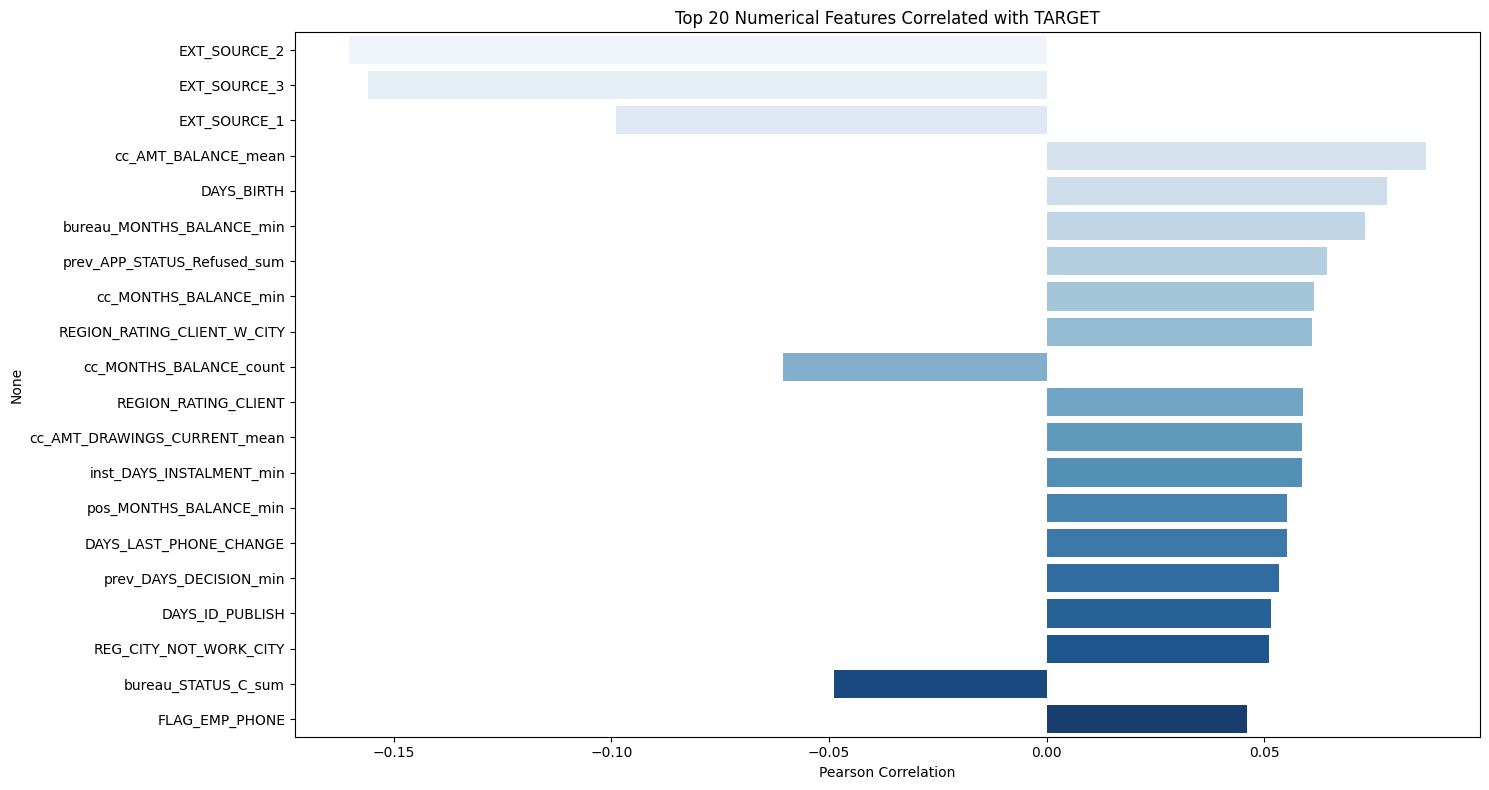

,PearsonCorr
EXT_SOURCE_2,-0.160295
EXT_SOURCE_3,-0.155892
EXT_SOURCE_1,-0.098887
cc_AMT_BALANCE_mean,0.087177
DAYS_BIRTH,0.078239
bureau_MONTHS_BALANCE_min,0.073225
prev_APP_STATUS_Refused_sum,0.064469
cc_MONTHS_BALANCE_min,0.061359
REGION_RATING_CLIENT_W_CITY,0.060893
cc_MONTHS_BALANCE_count,-0.060481


In [7]:

# Select numerical features only (float or int)
num_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['TARGET'], errors='ignore').columns

# Calculate Pearson correlation with TARGET
corr_target = df[num_cols].corrwith(df['TARGET']).sort_values(key=abs, ascending=False)

# Display top 20 correlations
top_corr = corr_target.head(20).to_frame(name='PearsonCorr')

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_corr['PearsonCorr'], y=top_corr.index, palette="Blues", hue=top_corr.index, legend=False)
plt.title('Top 20 Numerical Features Correlated with TARGET')
plt.xlabel('Pearson Correlation')
plt.tight_layout()
plt.show()

# Optional: display table
display(top_corr)


### Pearson Correlation Analysis (Numerical Features)

This step analyzes the **linear relationship** between numerical features and the target variable (`TARGET`) using **Pearson correlation coefficients**. The plot and table highlight the top 20 numerical features most correlated with default risk.

#### Key Observations:
- **Most negatively correlated features** (higher values → lower default risk): 

  - `EXT_SOURCE_2`: **−0.160** 

  - `EXT_SOURCE_3`: **−0.156** 

  - `EXT_SOURCE_1`: **−0.099**

- **Most positively correlated features** (higher values → higher default risk): 
  - `cc_AMT_BALANCE_mean`: **0.087** 

  - `DAYS_BIRTH`: **0.078** (Note: More negative `DAYS_BIRTH` → younger applicant → higher risk) 

  - `bureau_MONTHS_BALANCE_min`: **0.073** 

  - `prev_APP_STATUS_Refused_sum`: **0.064** 

- Many other features (e.g. `REGION_RATING_CLIENT`, `DAYS_LAST_PHONE_CHANGE`, `cc_MONTHS_BALANCE_min`) show mild but noticeable associations.

#### Insight:
- The top three `EXT_SOURCE` features are well-known predictive variables in this dataset and should be prioritized in model development. 

- Though correlations are weak in magnitude, this is common in real-world credit data. Features may still have **non-linear** relationships or become powerful when **interacted or modeled jointly**. 

- This analysis helps in **early feature prioritization**, but **feature importance and model-driven selection** will provide a clearer picture later.

---

### Cramer's V for Categorical Features Correlation

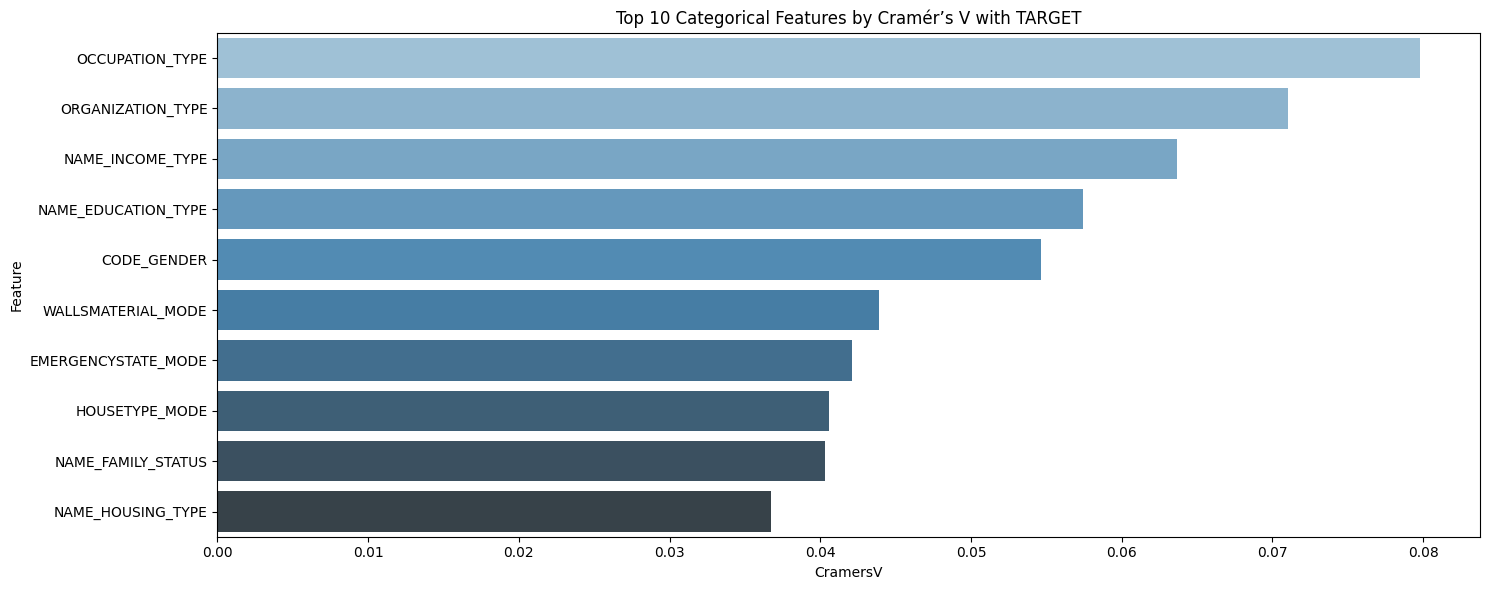

,Feature,CramersV
9,OCCUPATION_TYPE,0.079776
11,ORGANIZATION_TYPE,0.071048
5,NAME_INCOME_TYPE,0.063667
6,NAME_EDUCATION_TYPE,0.057458
1,CODE_GENDER,0.054661
14,WALLSMATERIAL_MODE,0.043878
15,EMERGENCYSTATE_MODE,0.042136
13,HOUSETYPE_MODE,0.040581
7,NAME_FAMILY_STATUS,0.040311
8,NAME_HOUSING_TYPE,0.036761


In [8]:
# Define function to calculate Cramér’s V with correction
def cramers_v_corrected(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Get only categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Store results
cramer_results = []

for col in cat_cols:
    try:
        confusion_mat = pd.crosstab(df[col], df['TARGET'])
        score = cramers_v_corrected(confusion_mat)
        cramer_results.append((col, score))
    except Exception as e:
        print(f"Could not compute Cramér’s V for: {col}, Error: {e}")

# Convert to DataFrame
cramer_df = pd.DataFrame(cramer_results, columns=['Feature', 'CramersV']).sort_values(by='CramersV', ascending=False)

# Plot top 10
plt.figure(figsize=(15,6))
sns.barplot(data=cramer_df.head(10), x='CramersV', y='Feature', palette='Blues_d', hue='Feature', legend=False)
plt.title("Top 10 Categorical Features by Cramér’s V with TARGET")
plt.tight_layout()
plt.show()

# Display full table
display(cramer_df)


### Top Categorical Features by Cramér’s V with Target

This step analyzes the association between categorical features and the binary target (`TARGET`) using **Cramér’s V**, a statistic that measures the strength of association between two nominal variables.

#### Observations:
- The **strongest associations** (though still weak in magnitude) are seen in: 

  - `OCCUPATION_TYPE` (≈ 0.08) 

  - `ORGANIZATION_TYPE` (≈ 0.071) 
  
  - `NAME_INCOME_TYPE` (≈ 0.064) 

  - `NAME_EDUCATION_TYPE` (≈ 0.057) 

- Other relevant features include: 

  - `CODE_GENDER`, `WALLSMATERIAL_MODE`, `EMERGENCYSTATE_MODE`, `HOUSETYPE_MODE`, etc.

#### Interpretation: 

- All Cramér’s V values are **less than 0.1**, indicating **weak associations**. 

- This is expected in real-world credit risk data, where categorical features rarely have strong standalone signals. 

- These features might still contribute value through **interactions** or when modeled with **non-linear approaches** like tree-based models or neural networks.

#### Note: 

- Weakly associated categorical variables may still hold value, especially when supported by **domain expertise** or in **combination with other features**. 

- Consider encoding strategies (e.g., **target encoding**, **frequency encoding**) to enhance their predictive power.

---



### Outlier Detection via IQR (Top Numerical Features)

,Feature,OutlierCount,OutlierPct
2,EXT_SOURCE_1,134131,43.62
8,REGION_RATING_CLIENT_W_CITY,78027,25.37
6,prev_APP_STATUS_Refused_sum,31021,10.09
3,cc_AMT_BALANCE_mean,6144,2.00
1,EXT_SOURCE_3,4313,1.40
0,EXT_SOURCE_2,0,0.00
4,DAYS_BIRTH,0,0.00
5,bureau_MONTHS_BALANCE_min,0,0.00
7,cc_MONTHS_BALANCE_min,0,0.00
9,cc_MONTHS_BALANCE_count,2,0.00


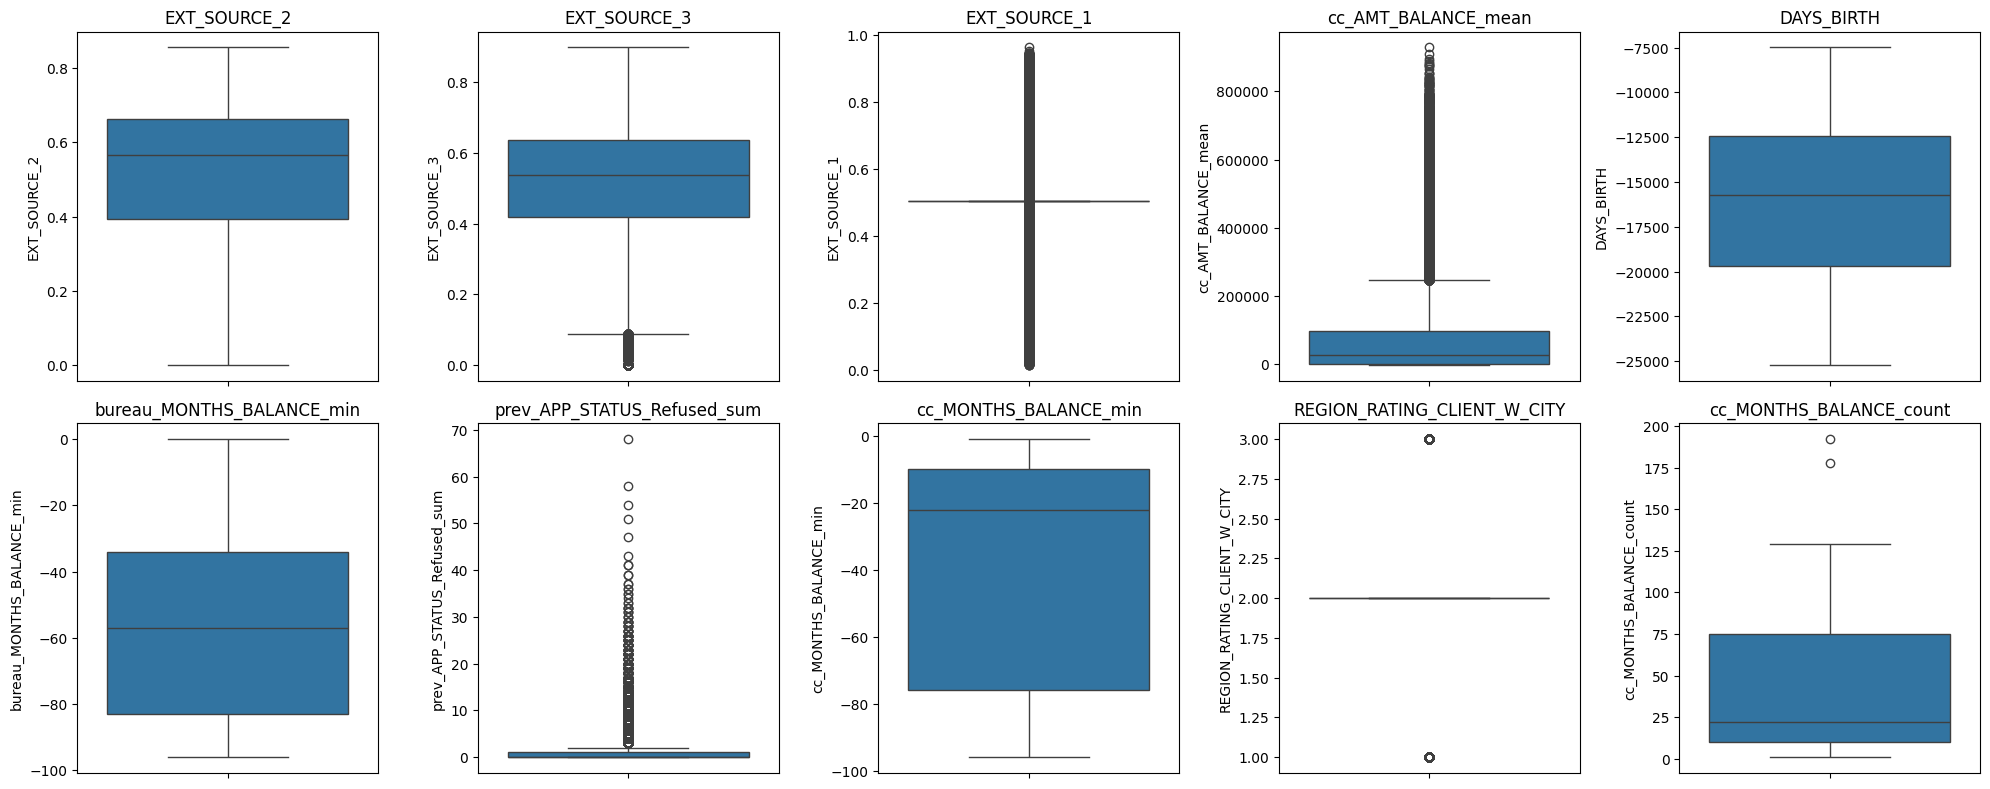

In [9]:
# Step 3G: Outlier Detection via IQR

# Top correlated numerical features (from previous Pearson step)
top_numerical = [
    "EXT_SOURCE_2", "EXT_SOURCE_3", "EXT_SOURCE_1",
    "cc_AMT_BALANCE_mean", "DAYS_BIRTH", "bureau_MONTHS_BALANCE_min",
    "prev_APP_STATUS_Refused_sum", "cc_MONTHS_BALANCE_min",
    "REGION_RATING_CLIENT_W_CITY", "cc_MONTHS_BALANCE_count"
]

outlier_summary = []

for col in top_numerical:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_pct = len(outliers) / len(df)

    outlier_summary.append({
        'Feature': col,
        'OutlierCount': len(outliers),
        'OutlierPct': round(outlier_pct * 100, 2)
    })

# Display outlier summary
outlier_df = pd.DataFrame(outlier_summary).sort_values(by="OutlierPct", ascending=False)
display(outlier_df)

# Optional: Boxplots to visualize distributions
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(top_numerical):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


### Outlier Detection Summary

We conducted outlier detection on the top 10 numerical features most correlated with the `TARGET` variable using the Interquartile Range (IQR) method.  
This was complemented with visual boxplots and tabulated outlier proportions.

#### Boxplot Observations:
- **EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3**: These normalized external scores are mostly distributed between 0 and 1, but `EXT_SOURCE_1` in particular has extreme values near 0 and 1, indicating heavy tails. 

- **cc_AMT_BALANCE_mean**: This feature shows high-magnitude outliers in the upper range, suggesting some clients maintain very high revolving balances. 

- **prev_APP_STATUS_Refused_sum**: Contains visible outliers representing clients with significantly more past refused applications than the median. 

- **REGION_RATING_CLIENT_W_CITY**: Displays a very limited set of values, yet one value appears more extreme than the rest. 

- **Other features** such as `DAYS_BIRTH` and `cc_MONTHS_BALANCE_*` show relatively stable distributions with no meaningful outliers.


#### Outlier Counts and Ratios:

| Feature                        | Outlier Count | Outlier % |
|-------------------------------|---------------|-----------|
| EXT_SOURCE_1                  | 134,131       | 43.62%    |
| REGION_RATING_CLIENT_W_CITY   | 78,027        | 25.37%    |
| prev_APP_STATUS_Refused_sum   | 31,021        | 10.09%    |
| cc_AMT_BALANCE_mean           | 6,144         | 2.00%     |
| EXT_SOURCE_3                  | 4,313         | 1.40%     |
| EXT_SOURCE_2                  | 0             | 0.00%     |
| DAYS_BIRTH                    | 0             | 0.00%     |
| bureau_MONTHS_BALANCE_min     | 0             | 0.00%     |
| cc_MONTHS_BALANCE_min         | 0             | 0.00%     |
| cc_MONTHS_BALANCE_count       | 2             | 0.00%     |


#### Insights:
- **EXT_SOURCE_1** has the highest proportion of outliers and may benefit from robust transformation (e.g., log, winsorization, or RobustScaler). 

- **REGION_RATING_CLIENT_W_CITY** likely contains only 3 discrete values (1, 2, 3), with 3 being rare — consider treating this as ordinal categorical. 

- **prev_APP_STATUS_Refused_sum** outliers likely reflect a small subset of high-risk clients; retain this signal carefully. 

- Features like `DAYS_BIRTH` and balance-related features show no significant outliers, suggesting stable distributions. 

####  Recommendations:
- Apply **robust scaling** to `EXT_SOURCE_1` and `REGION_RATING_CLIENT_W_CITY`. 

- Cap or **clip outliers** in `prev_APP_STATUS_Refused_sum` if extreme values cause instability. 

- Maintain original distributions for features with no or low outlier percentages. 

- Ensure all outlier-handling is done **within pipelines** to avoid data leakage during modeling.

---



### Outlier Impact Analysis

In [10]:
# --- 1. Outlier removal function using IQR ---
def remove_outliers_iqr(X, y, threshold=1.5):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - threshold * IQR)) | (X > (Q3 + threshold * IQR))).any(axis=1)
    return X[mask], y[mask]

# --- 2. Define input features and target ---
X = df.drop(columns=['TARGET'])  # Assuming df is your final EDA-ready DataFrame
y = df['TARGET']

# Remove outliers
X_no_outliers, y_no_outliers = remove_outliers_iqr(X.select_dtypes(include='number'), y)

# Drop columns with missing values for this temporary evaluation
X_clean = X.select_dtypes(include='number').dropna(axis=1)
X_no_outliers_clean = X_no_outliers[X_clean.columns]

# --- 3. Evaluation function ---
def evaluate_model(X, y, label="Model"):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")
    print(f"{label} ROC-AUC: Mean={scores.mean():.4f}, Std={scores.std():.4f}")
    return scores

# --- 4. Evaluate both scenarios ---
print(" Evaluating model with outliers:")
scores_with = evaluate_model(X_clean, y, label="With Outliers")

print("\n Evaluating model without outliers:")
scores_without = evaluate_model(X_no_outliers_clean, y_no_outliers, label="Without Outliers")


 Evaluating model with outliers:
With Outliers ROC-AUC: Mean=0.7344, Std=0.0050

 Evaluating model without outliers:
Without Outliers ROC-AUC: Mean=0.7157, Std=0.0430


### Outlier Impact on Model Performance (Logistic Regression)

We evaluated a baseline logistic regression model using only numerical features, once **with outliers** and once **after removing outliers** via the IQR method.

| Evaluation Scenario       | Mean ROC-AUC | Std Dev |
|--------------------------|--------------|---------|
|   With Outliers          | **0.7344**    | 0.0050  |
|   Without Outliers       | 0.7157        | 0.0430  |

**Interpretation:**

- The model **performs better with outliers retained**, both in terms of ROC-AUC and consistency (low standard deviation).
- Removing outliers **reduced performance** and **increased variance**, likely due to loss of important edge cases or shrinking the sample size.
- This suggests that outliers in our credit data **may carry useful information**, especially for predicting rare events like default.

**Conclusion:**  
We will **not remove outliers globally**. Instead, we will **handle extreme values selectively** in the preprocessing pipeline (e.g., winsorization, transformation) if they negatively affect model robustness.

---

### Multicollinearity Detection

In [11]:

# Select numeric features
numeric_df = df.select_dtypes(include=['int64', 'float64']).drop(columns=['TARGET'], errors='ignore')

# Drop columns with missing values for clean correlation analysis
numeric_df_clean = numeric_df.dropna(axis=1)

# Compute correlation matrix
corr_matrix = numeric_df_clean.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find highly correlated pairs
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={0: 'Correlation', 'level_0': 'Feature_1', 'level_1': 'Feature_2'})
    .query('Correlation > 0.85')
    .sort_values(by='Correlation', ascending=False)
)

# Display result
print(f"Found {high_corr_pairs.shape[0]} highly correlated pairs (corr > 0.85):")
display(high_corr_pairs.head(20))


Found 64 highly correlated pairs (corr > 0.85):


,Feature_1,Feature_2,Correlation
557,DAYS_EMPLOYED,FLAG_EMP_PHONE,0.999755
2155,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998495
3349,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.998491
2395,FLOORSMIN_AVG,FLOORSMIN_MEDI,0.997278
2349,FLOORSMAX_AVG,FLOORSMAX_MEDI,0.997260
2302,ENTRANCES_AVG,ENTRANCES_MEDI,0.996900
2254,ELEVATORS_AVG,ELEVATORS_MEDI,0.996692
2205,COMMONAREA_AVG,COMMONAREA_MEDI,0.996229
2527,LIVINGAREA_AVG,LIVINGAREA_MEDI,0.995783
1999,APARTMENTS_AVG,APARTMENTS_MEDI,0.995234


### Multicollinearity Detection (Pearson Correlation Matrix)

We examined multicollinearity among numerical features by computing the Pearson correlation matrix and identifying highly correlated pairs (correlation > **0.85**).

#### Findings:
- **Total highly correlated pairs found**: **64** 

- Many of these are expected duplicates or near-duplicates representing different aggregations (e.g., `AVG`, `MEDI`, `MODE`), especially among housing-related features like:
  - `YEARS_BUILD_AVG` vs `YEARS_BUILD_MEDI` (r = 0.998) 

  - `FLOORSMIN_AVG` vs `FLOORSMIN_MEDI` (r = 0.998) 

  - `LIVINGAREA_AVG` vs `LIVINGAREA_MEDI` (r = 0.996)

#### Examples of Redundant Feature Pairs:
| Feature 1                  | Feature 2                  | Correlation |
|---------------------------|----------------------------|-------------|
| DAYS_EMPLOYED             | FLAG_EMP_PHONE             | 0.9998      |
| YEARS_BUILD_AVG           | YEARS_BUILD_MEDI           | 0.9985      |
| OBS_30_CNT_SOCIAL_CIRCLE  | OBS_60_CNT_SOCIAL_CIRCLE   | 0.9985      |
| FLOORSMIN_AVG             | FLOORSMIN_MEDI             | 0.9973      |
| ENTRANCES_AVG             | ENTRANCES_MEDI             | 0.9970      |

#### Interpretation:
- These strong correlations imply **multicollinearity**, which can inflate variance and weaken model interpretability (especially for linear models). 

- Since features like `AVG`, `MEDI`, and `MODE` versions are near-duplicates, **only one per group should be retained**. 

- The pair `DAYS_EMPLOYED` and `FLAG_EMP_PHONE` has a surprisingly high correlation (~0.999),  
suggesting a likely **data leakage** or **feature engineering artifact** that should be investigated.

#### Actionable Suggestions:
- Keep only one representative from highly correlated feature groups (e.g., `AVG`). 

- Drop or consolidate redundant aggregations to reduce noise and overfitting. 

- For tree-based models, this is less critical, but for logistic regression or neural networks, **removing multicollinearity improves robustness**.

---


## EDA

### Univariate Distribution of Key Numerical Features

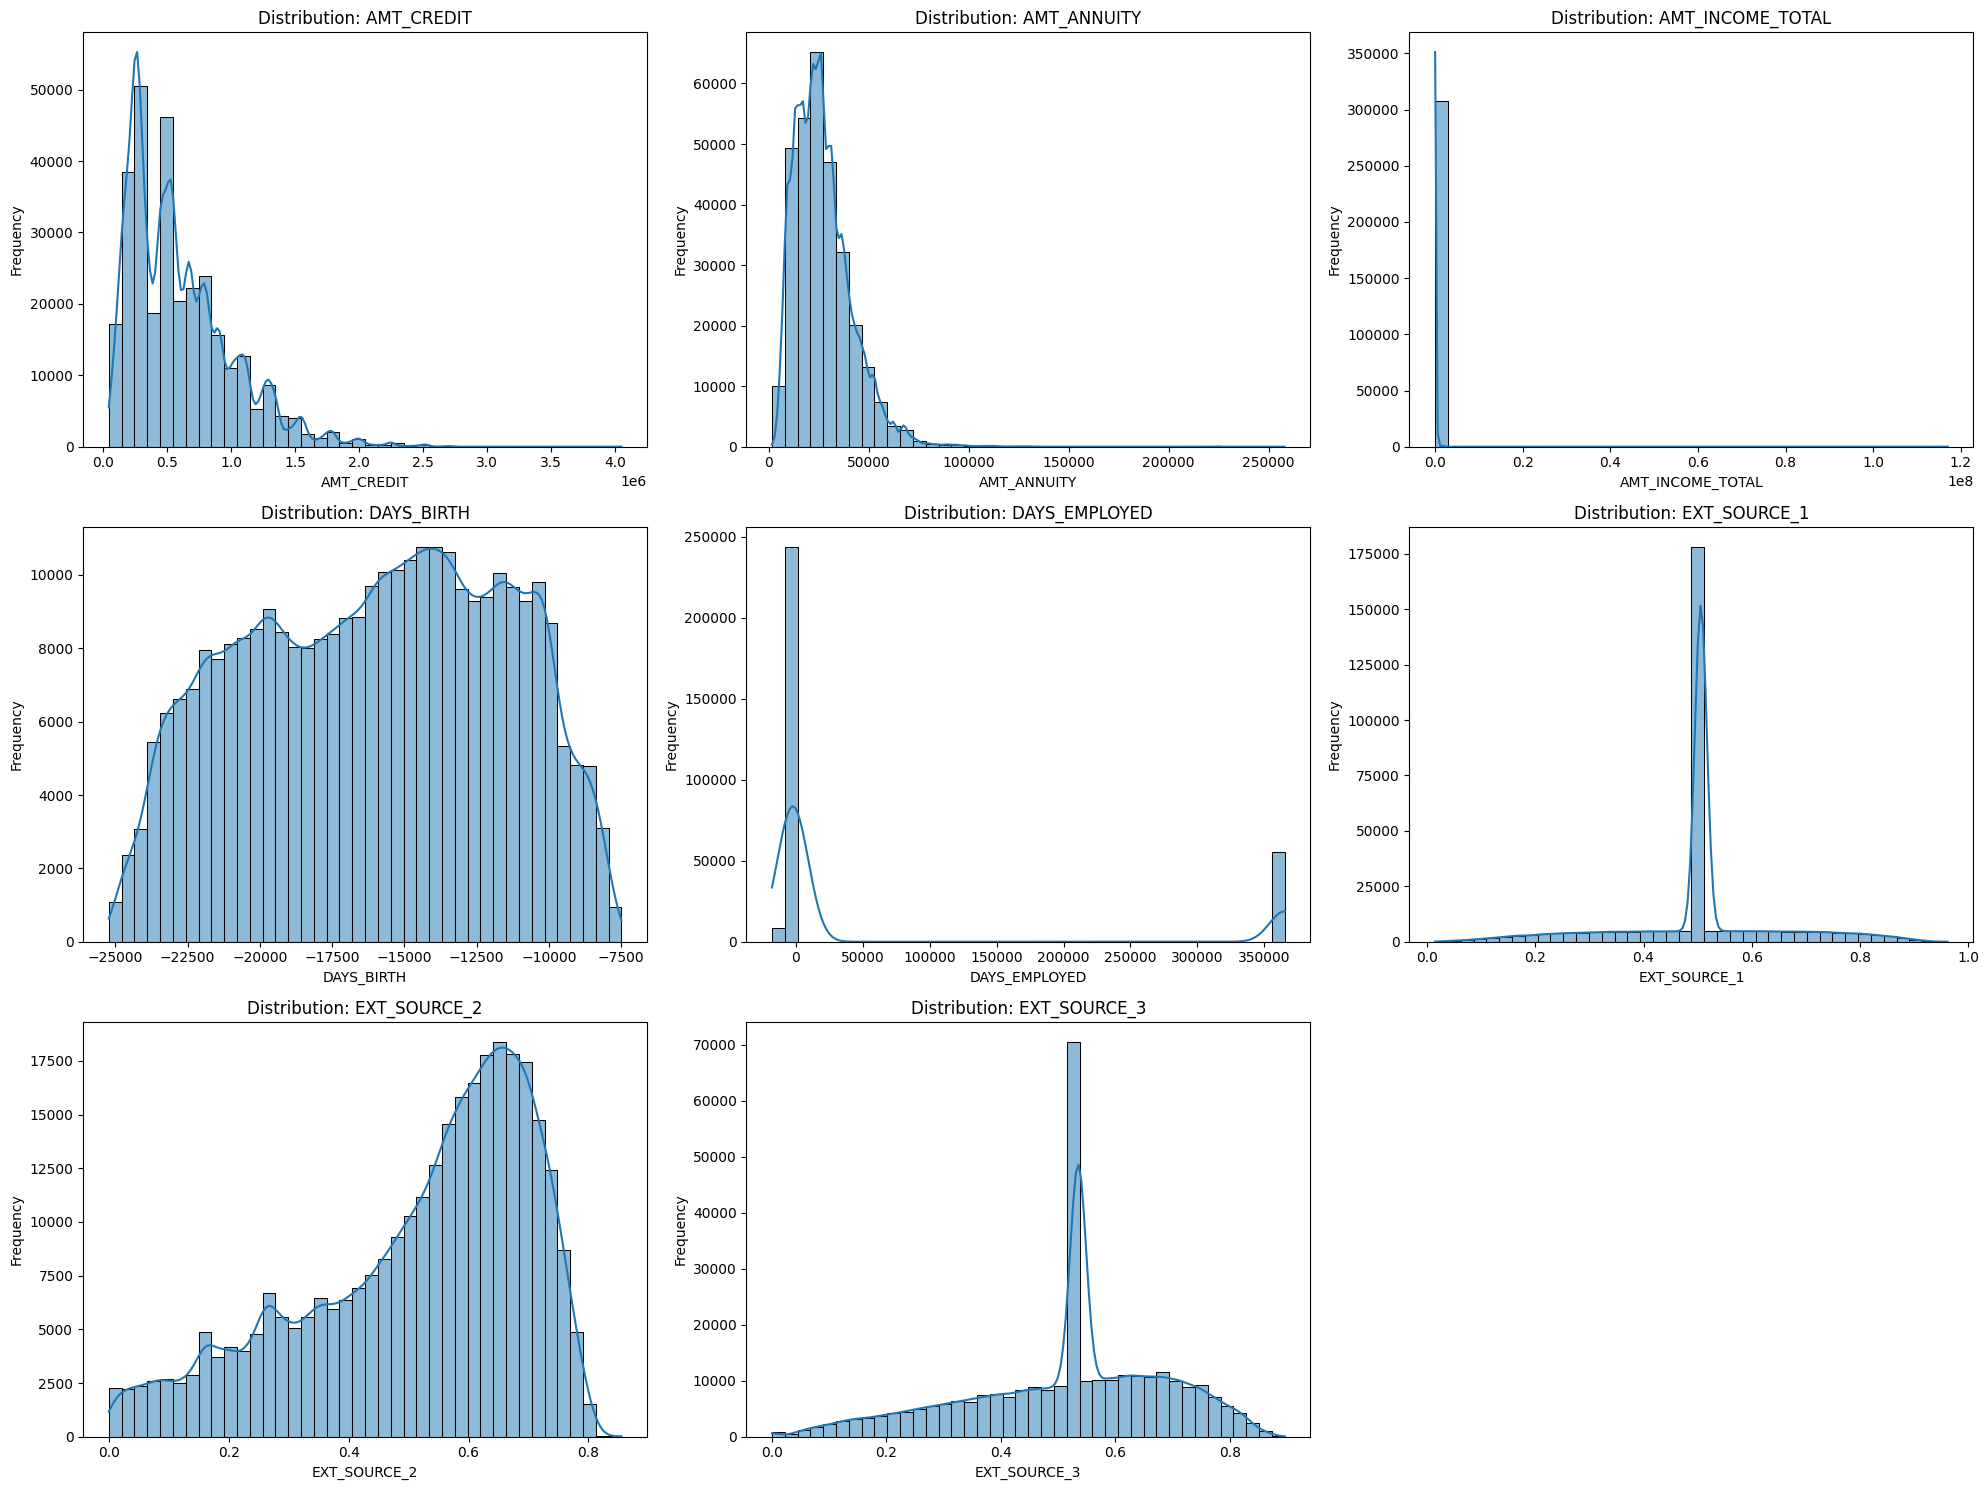

In [12]:
# Select key numerical features to inspect
num_cols = [
    "AMT_CREDIT", "AMT_ANNUITY", "AMT_INCOME_TOTAL",
    "DAYS_BIRTH", "DAYS_EMPLOYED", "EXT_SOURCE_1",
    "EXT_SOURCE_2", "EXT_SOURCE_3"
]

# Plot distributions
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Distribution Analysis of Key Numerical Features

To understand the central tendencies, dispersion, and skewness of important numerical features, we examined the histograms and KDE plots of the most relevant variables:

#### Credit and Income Features

- **AMT_CREDIT** and **AMT_ANNUITY** both show **right-skewed** distributions,  
which is expected since most loans are smaller while a few very large credits pull the tail. 

- **AMT_INCOME_TOTAL** is extremely skewed with outliers exceeding 100 million. This will need further capping or log-transformation before modeling.

#### Temporal Features

- **DAYS_BIRTH** has a symmetric but negative-valued distribution (due to how days are stored).  
This is expected and shows a central tendency around -15000 (~41 years). 

- **DAYS_EMPLOYED** has an extreme spike near 365243, a placeholder indicating a **special condition** (likely unemployment, retirement, or unknown status).  
This should be handled explicitly.

#### External Risk Scores

- **EXT_SOURCE_1**, **EXT_SOURCE_2**, and **EXT_SOURCE_3** all fall in the [0, 1] range. 
  - **EXT_SOURCE_2** is left-skewed. 

  - **EXT_SOURCE_3** and **EXT_SOURCE_1** show tight central tendencies with narrow spreads. 

  - These are known to be strong predictors of credit risk based on prior analyses and should be preserved as-is after imputing missing values.

#### Summary

- Many features have **significant skew** and **outliers**. 

- Key transformations such as **log-scaling**, **winsorization**, or **normalization** may be necessary before feeding into models. 

- Special values (e.g., 365243 in `DAYS_EMPLOYED`) must be addressed explicitly to avoid misleading results.

---


### Bivariate distributions vs TARGET

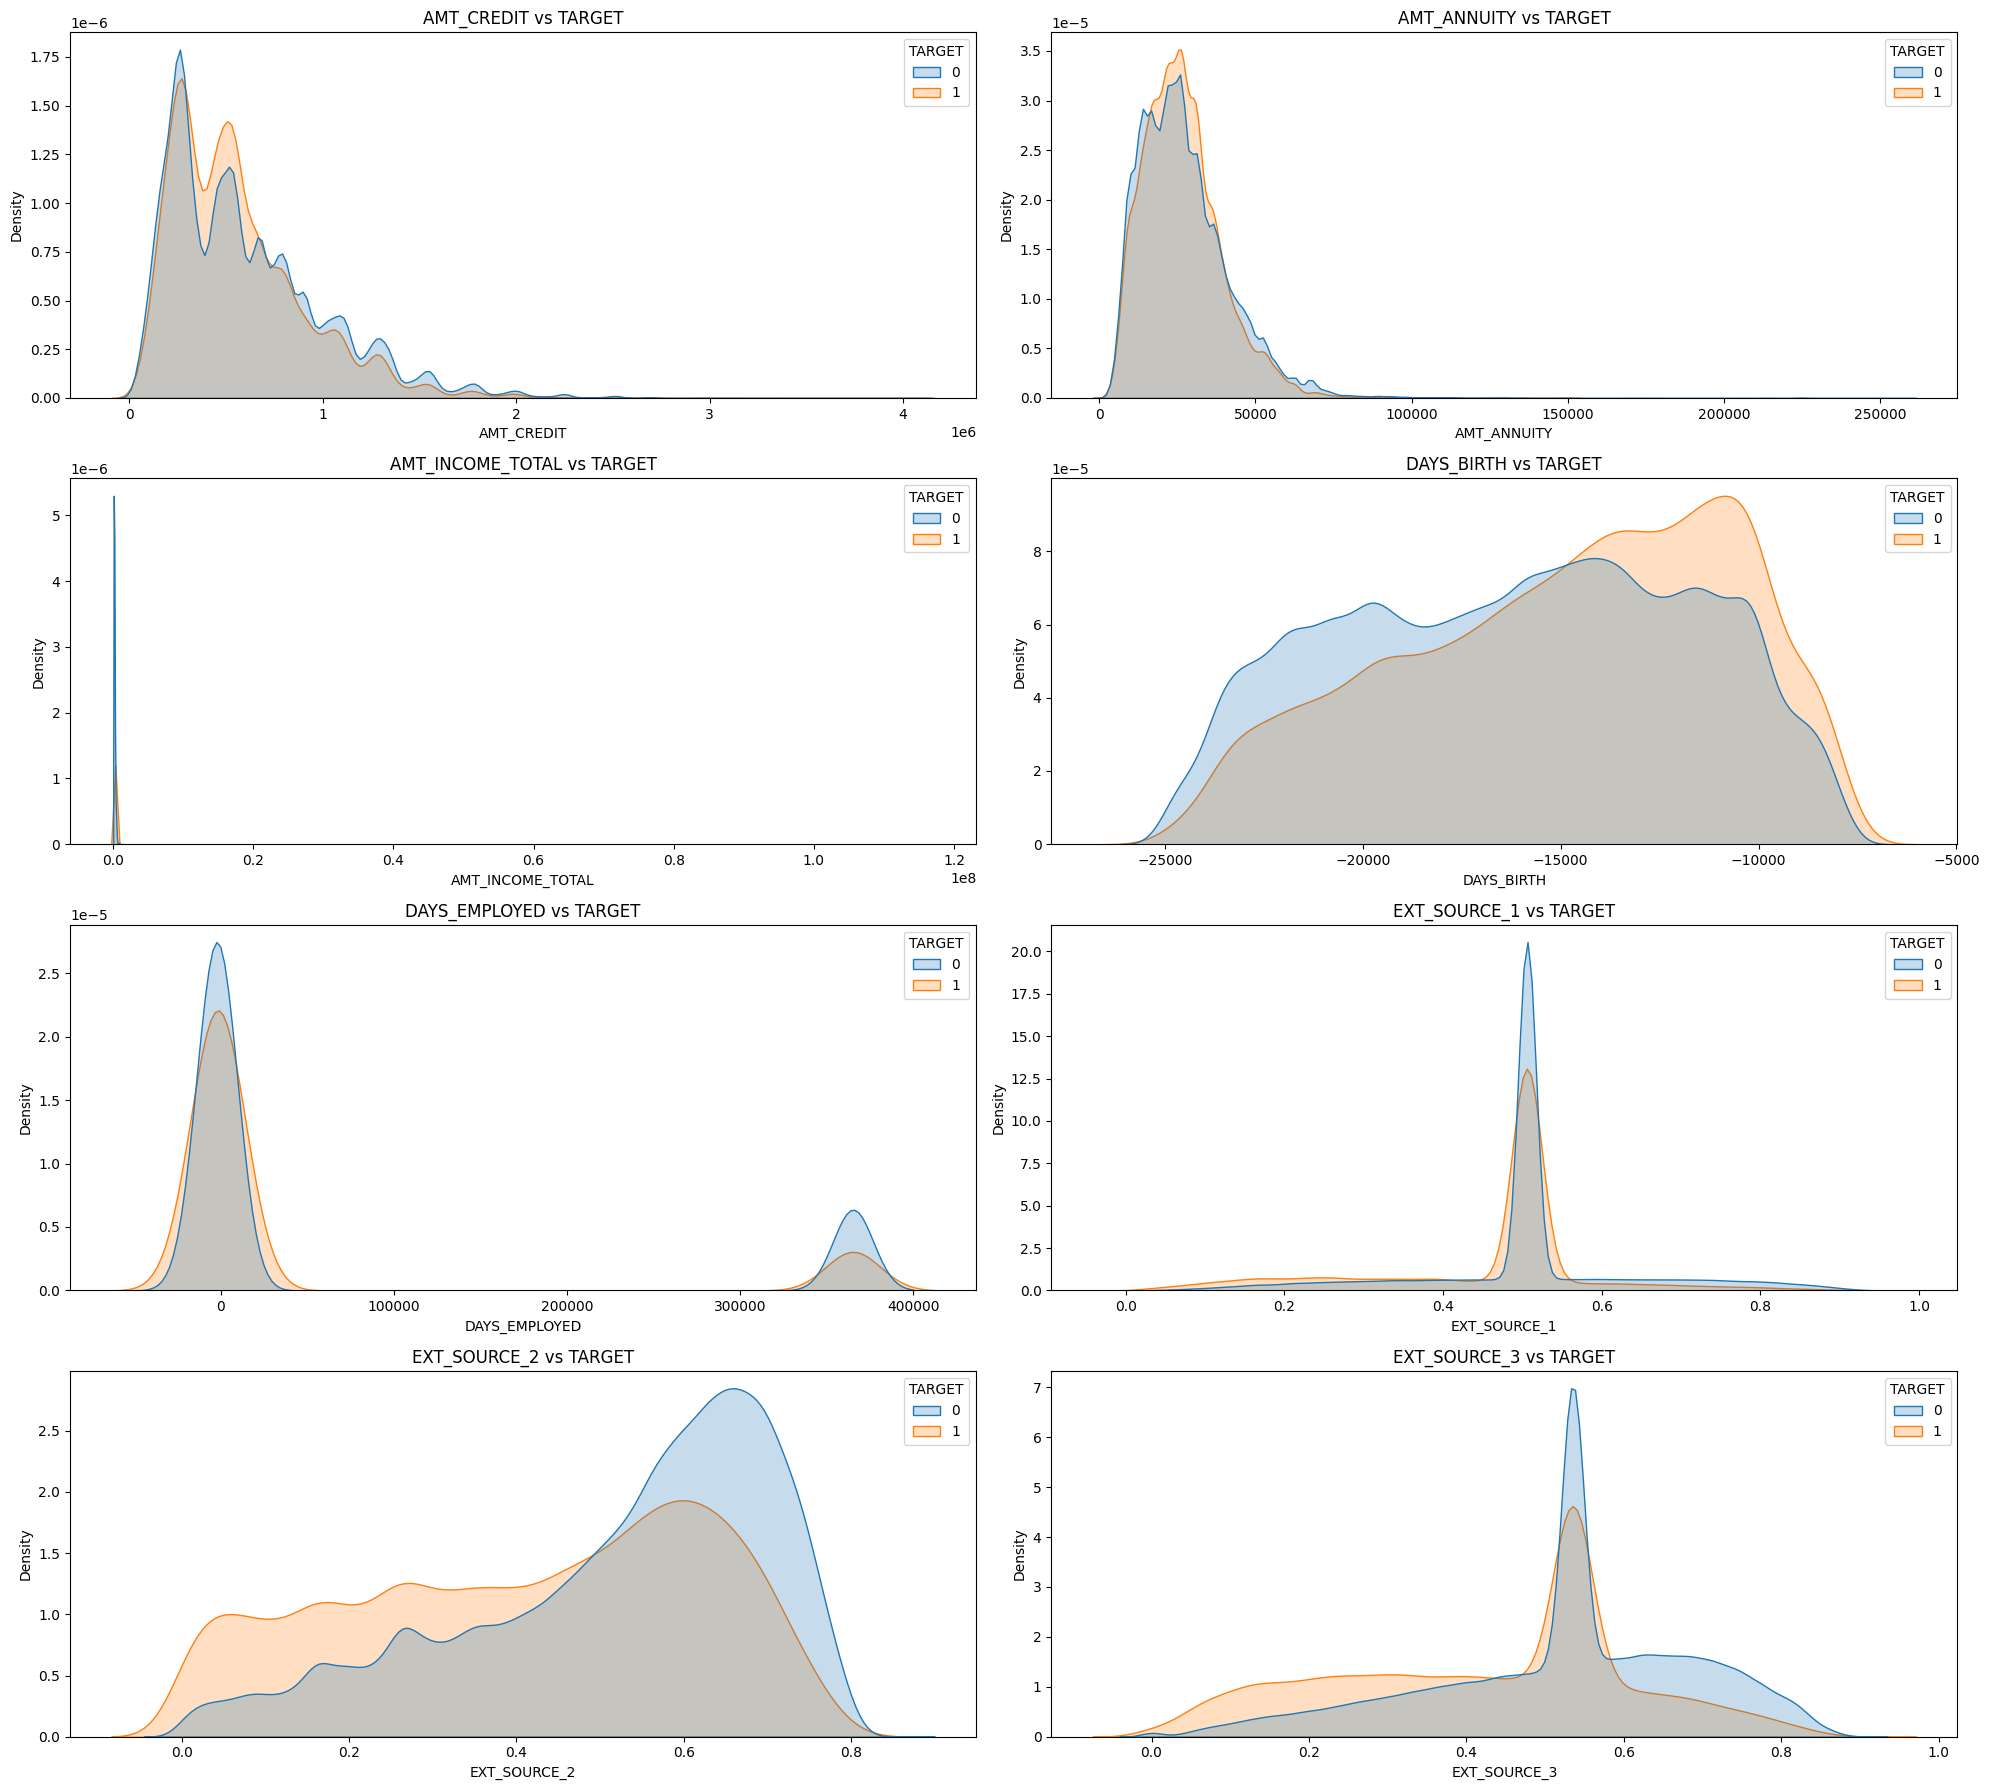

In [13]:
# Define top features to explore
bivariate_features = [
    "AMT_CREDIT", "AMT_ANNUITY", "AMT_INCOME_TOTAL",
    "DAYS_BIRTH", "DAYS_EMPLOYED",
    "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"
]

# Plot KDE distributions of numerical features by TARGET
plt.figure(figsize=(20, 18))
for i, col in enumerate(bivariate_features, 1):
    plt.subplot(4, 2, i)
    sns.kdeplot(data=df, x=col, hue="TARGET", common_norm=False, fill=True)
    plt.title(f"{col} vs TARGET")
plt.tight_layout()
plt.show()


### Numerical Features vs. TARGET (Density Comparison)

This section visualizes the distribution of key numerical features across the two target classes (`TARGET = 0` for non-default, `TARGET = 1` for default). Density plots help identify class separation and potential predictive power.

#### 1. `AMT_CREDIT`
- Distribution is **positively skewed** for both classes. 

- Defaulted clients (`TARGET = 1`) tend to have **lower credit amounts** overall. 

- A more pronounced drop-off in the right tail for defaulters, suggesting higher credit values are associated with better repayment behavior.

#### 2. `AMT_ANNUITY`
- Defaulting clients tend to have **lower annuity payments**. 

- The class separation is subtle but visible, particularly in the **low-to-mid range**. 

- May contribute modest predictive value when combined with other features.

#### 3. `AMT_INCOME_TOTAL`
- Highly **right-skewed** with extreme outliers. 

- **No clear separation** between default and non-default groups. 

- Suggests that income level alone may not determine default risk, or that **log transformation** or **outlier treatment** may be necessary.

#### 4. `DAYS_BIRTH`
- Represents age in negative days (closer to 0 = younger). 

- Clients who default are generally **younger**, while non-defaulters peak around older ages. 

- **Strong signal**: older clients tend to be more reliable.

### 5. `DAYS_EMPLOYED`
- Dense spike at ~365243 days suggests **placeholder/missing** or **retirees**. 

- Excluding that, defaulters tend to have **shorter employment durations**. 

- Important to handle extreme values separately to avoid bias.

### 6. `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`

- These are normalized external credit scores (0–1). 

- Lower values are consistently associated with **higher default risk**. 

- `EXT_SOURCE_2` shows the **clearest class separation**, followed by `EXT_SOURCE_1` and `EXT_SOURCE_3`. 

- These are **strong predictive variables**.

**Insight:**  

Several features—especially `DAYS_BIRTH`, `DAYS_EMPLOYED`, and the `EXT_SOURCE` scores—show **clear class separation**, reinforcing their value in model training.



### Bivariate EDA for Categorical Features vs TARGET

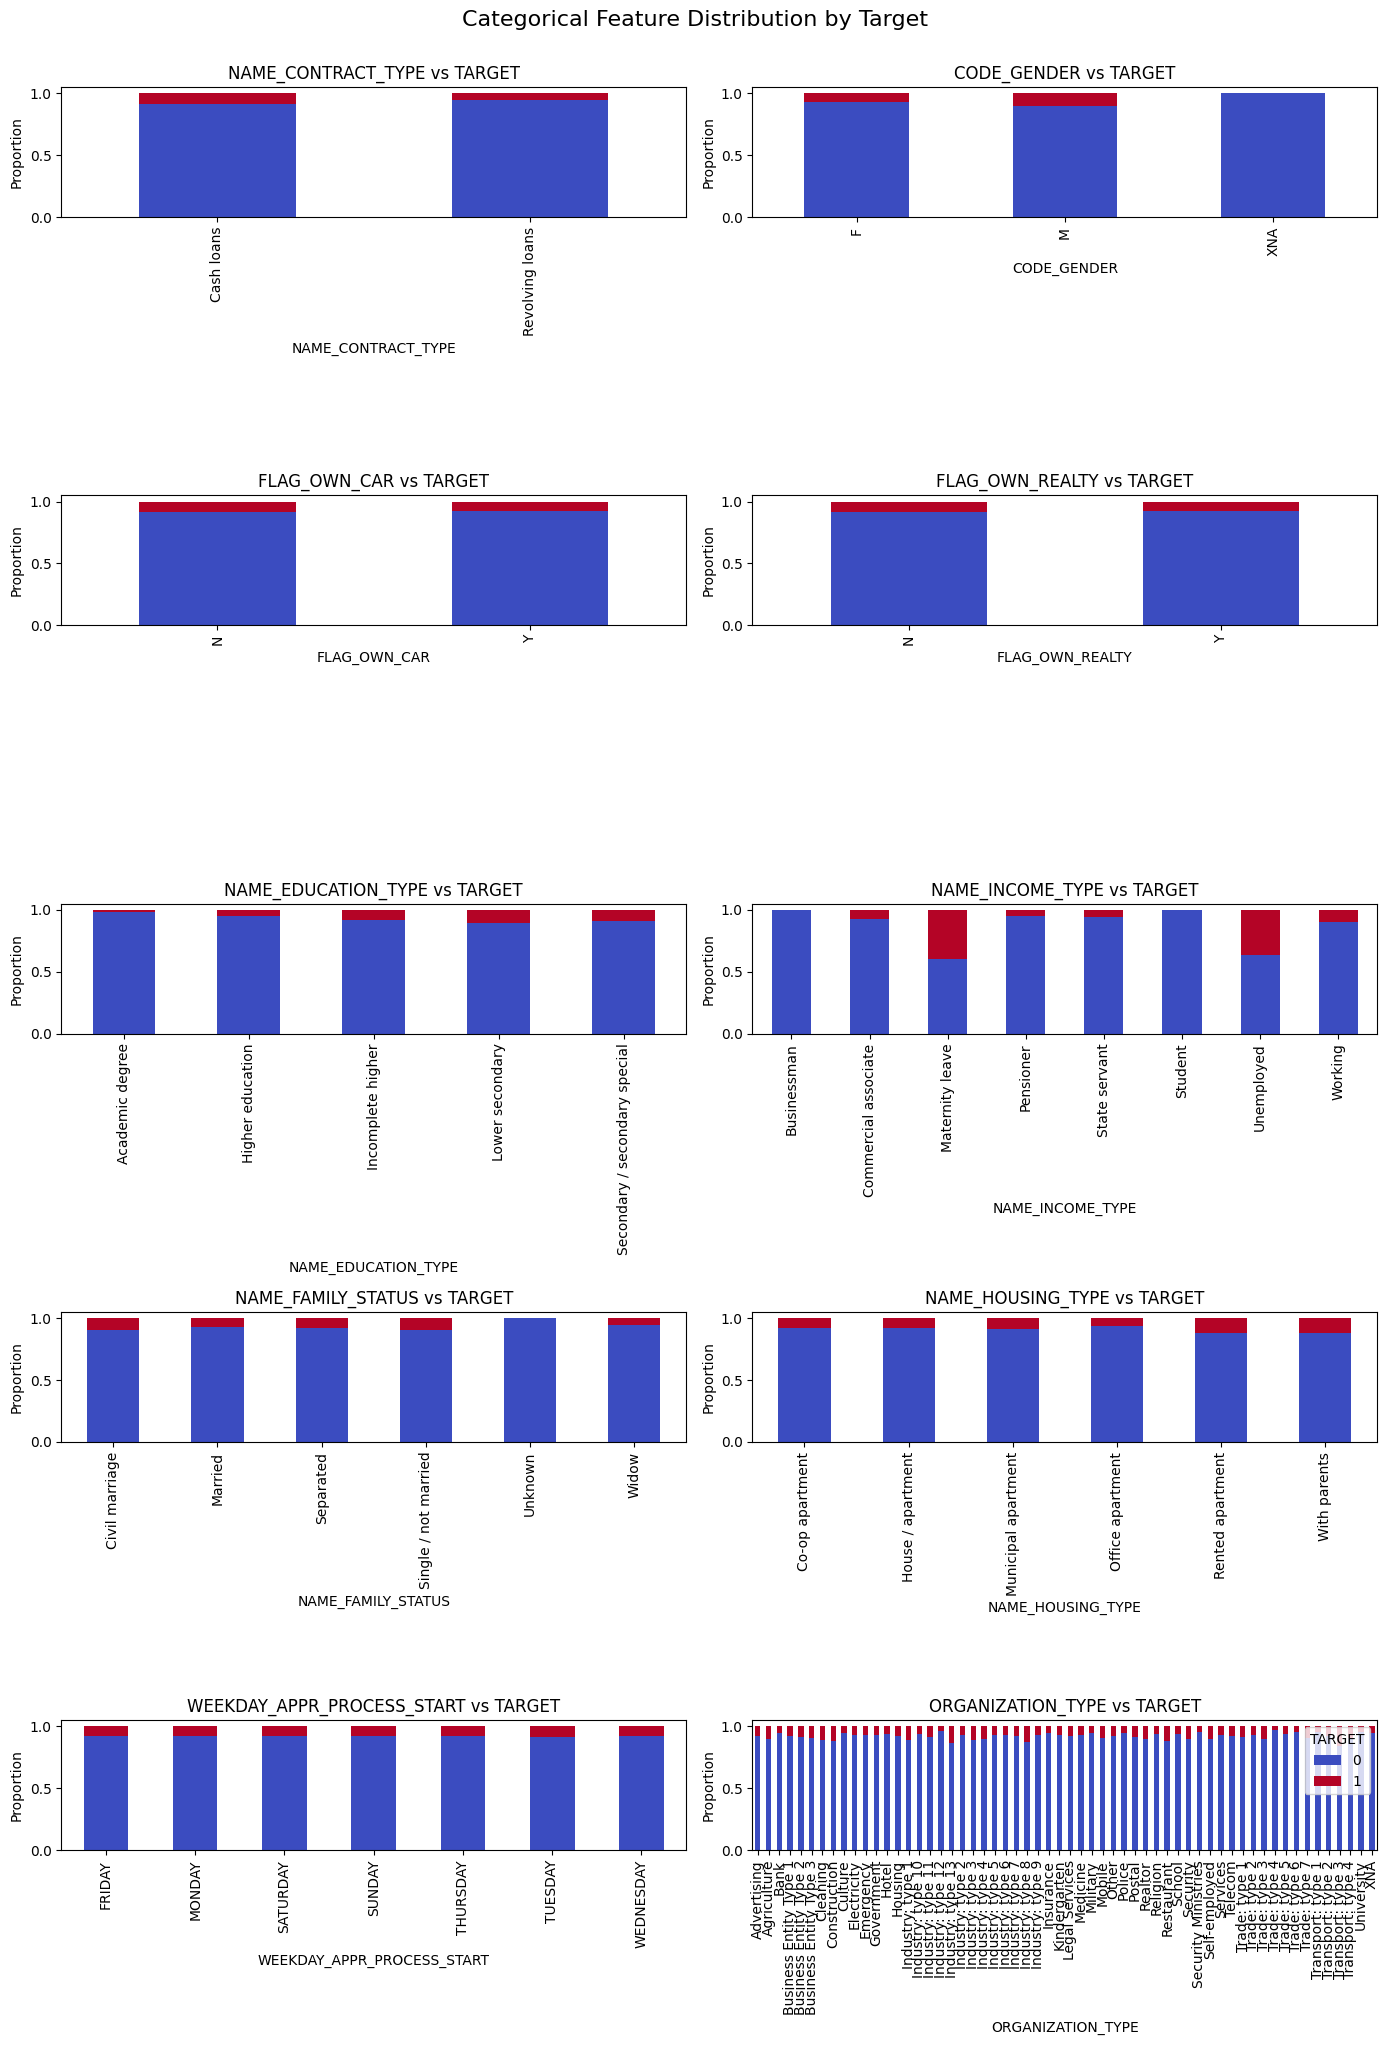

In [14]:
# Define top categorical features to inspect (adjust as needed)
cat_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'
]

# Plotting
n_cols = 2
n_rows = (len(cat_features) + 1) // n_cols

plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(cat_features):
    plt.subplot(n_rows, n_cols, i + 1)
    prop_df = df.groupby([col, 'TARGET']).size().unstack().fillna(0)
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
    prop_df.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False, colormap='coolwarm')
    plt.title(f'{col} vs TARGET')
    plt.ylabel('Proportion')
    plt.xlabel(col)

plt.tight_layout()
plt.legend(title='TARGET', loc='upper right')
plt.suptitle('Categorical Feature Distribution by Target', fontsize=16, y=1.02)
plt.show()


### Categorical Feature Distribution by Target 
This section explores how categorical variables vary between defaulted (TARGET=1) and non-defaulted (TARGET=0) clients.  
Each subplot displays the proportion of each category by target class, helping identify predictive categorical signals.

#### `NAME_CONTRACT_TYPE`
- The majority of applicants have **Cash loans**, with a small minority having **Revolving loans**. 

- There is a slightly higher proportion of defaults (red bars) among Revolving loans.

**Insight:** Revolving loans may carry higher credit risk than cash loans.

#### `CODE_GENDER`
- Distribution is skewed toward **Females (F)**. 

- **Males (M)** have a marginally higher default rate. 

- `XNA` is rare and should be treated as noise or imputed.

**Insight:** Gender has weak influence on default, but caution is advised in ethical handling.

#### `FLAG_OWN_CAR & FLAG_OWN_REALTY` 

- Slightly higher default proportion among applicants who **do not own a car or real estate**. 

- Differences are small.

**Insight:** Asset ownership may provide some signal but is not highly discriminative alone. 

#### `NAME_EDUCATION_TYPE`
- **Secondary/secondary special** education is the most common. 

- **Lower secondary** and **Incomplete higher** show higher default proportions. 

- **Higher education** and **Academic degree** correlate with lower default rates.

**Insight:** Education level is inversely related to default probability.

#### `NAME_INCOME_TYPE`
- Very high default ratios for **Unemployed**, **Maternity leave**, and **Student**. 

- **Pensioners**, **Working**, and **State servant** groups show lower default rates.

**Insight:** Income stability is a strong credit risk signal.

#### `NAME_FAMILY_STATUS`
- **Single/not married** and **Separated** applicants show slightly elevated defaults. 

- **Married** and **Civil marriage** groups have lower risk.

**Insight:** Family status has modest predictive value, potentially linked to household financial support.

#### `NAME_HOUSING_TYPE`
- Distribution across categories is fairly uniform. 

- No strong differences in default proportions.

**Insight:** Housing type appears to offer limited predictive value.

#### `WEEKDAY_APPR_PROCESS_START`
- Default proportions are consistent across days of the week.

**Insight:** Application day does not significantly affect default risk.

#### `ORGANIZATION_TYPE`
- High-cardinality variable with small differences across many categories. 

- Slightly elevated default rates observed in **Construction**, **Industry types**, and **Security Ministries**.

**Insight:** This feature is potentially useful but may require grouping or target encoding.

#### Summary
- **Strong signals**: `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `ORGANIZATION_TYPE` 

- **Moderate signals**: `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `NAME_CONTRACT_TYPE` 

- **Weak/No signal**: `WEEKDAY_APPR_PROCESS_START`, `NAME_HOUSING_TYPE`




## Statitical Inference 

### Hypotheses

| Step | Hypothesis Description                                                   | Variable Type         | Test Type                | Features                      |
| ---- | ------------------------------------------------------------------------ | --------------------- | ------------------------ | ----------------------------- |
| 1    | Default rate varies by **income type**                                   | Categorical vs Binary | Chi-Square               | `NAME_INCOME_TYPE` × `TARGET` |
| 2    | Average **credit amount** differs between defaulters and non-defaulters  | Continuous vs Binary  | t-test or Mann–Whitney U | `AMT_CREDIT` × `TARGET`       |
| 3    | Mean **age (DAYS\_BIRTH)** differs between defaulters and non-defaulters | Continuous vs Binary  | t-test or Mann–Whitney U | `DAYS_BIRTH` × `TARGET`       |


### Hypothesis 1 

H₀ - Default Rate doesn't vary by Income Type 

H₁ - Defualt Rate Varies by Income Type

In [15]:
# Step 4A: Chi-Square Test between NAME_INCOME_TYPE and TARGET
contingency_income = pd.crosstab(df['NAME_INCOME_TYPE'], df['TARGET'])
chi2, p, dof, expected = chi2_contingency(contingency_income)

print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

# Show contingency table
display(contingency_income)


Chi-Square Statistic: 1253.4708080924986
Degrees of Freedom: 7
P-value: 1.9281456056861126e-266


TARGET,0,1
NAME_INCOME_TYPE,,
Businessman,10,0
Commercial associate,66257,5360
Maternity leave,3,2
Pensioner,52380,2982
State servant,20454,1249
Student,18,0
Unemployed,14,8
Working,143550,15224


### Hypothesis Test 1: Default Rate vs Income Type

**Hypotheses:**
- **H₀ (Null Hypothesis):** Default rate does **not** vary by income type. 

- **H₁ (Alternative Hypothesis):** Default rate **does** vary by income type.

**Test Chosen:** Chi-Square Test of Independence  

**Justification:** Both variables (`NAME_INCOME_TYPE` and `TARGET`) are categorical.

---

**Contingency Table (TARGET by Income Type):**

| Income Type           | TARGET = 0 | TARGET = 1 |
|------------------------|------------|------------|
| Businessman            | 10         | 0          |
| Commercial associate   | 66,257     | 5,360      |
| Maternity leave        | 3          | 2          |
| Pensioner              | 52,380     | 2,982      |
| State servant          | 20,454     | 1,249      |
| Student                | 18         | 0          |
| Unemployed             | 14         | 8          |
| Working                | 143,550    | 15,224     |


**Test Results:** 

- **Chi-Square Statistic:** 1253.47  

- **Degrees of Freedom:** 7  

- **P-value:** 1.93 × 10⁻²⁶⁶


**Conclusion:**
- Since the **p-value < 0.05**, we **reject the null hypothesis**. 

- This provides strong evidence that **default rate varies significantly across income types**.

**Insight:**
- Some income groups, especially *Unemployed* and *Pensioners*, show elevated default rates. 

- This suggests that `NAME_INCOME_TYPE` is a potentially **important predictor** for credit risk modeling.


### Hypothesis 2

H₀ (Null Hypothesis): Default rate does not vary by gender. 

H₁ (Alternative Hypothesis): Default rate does vary by gender. 

Because both CODE_GENDER and TARGET are categorical, we will use a Chi-Square Test of Independence. 

In [16]:
contingency_gender = pd.crosstab(df['CODE_GENDER'], df['TARGET'])

# Run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_gender)

# Print test results
print("Chi–Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

# Display the table
display(contingency_gender)


Chi–Square Statistic: 920.7913340361749
Degrees of Freedom: 2
P-value: 1.1290217848908289e-200


TARGET,0,1
CODE_GENDER,,
F,188278,14170
M,94404,10655
XNA,4,0


### Hypothesis 2: Default Rate vs Gender

#### **Hypotheses**
- **H₀ (Null Hypothesis):** Default rate does **not** vary by gender. 

- **H₁ (Alternative Hypothesis):** Default rate **varies** by gender.

#### **Test Used**
- **Chi-Square Test of Independence**  
  (Appropriate for categorical vs. categorical variable comparisons)

#### **Results**
- **Chi-Square Statistic:** 920.79  

- **Degrees of Freedom:** 2  

- **P-value:** 1.13 × 10⁻²⁰⁰

#### **Contingency Table**
| CODE_GENDER | Non-Default (0) | Default (1) |
|-------------|------------------|-------------|
| F           | 188,278          | 14,170      |
| M           | 94,404           | 10,655      |
| XNA         | 4                | 0           |

#### **Interpretation**
- The p-value is extremely small (<< 0.05), so we **reject the null hypothesis**. 

- This provides **strong statistical evidence** that default rates **do vary by gender**. 

- Notably, although women (F) have a higher representation in the dataset, **men (M) have a higher relative proportion of defaults** based on this contingency table.


### Hypothesis 3: Mean AMT_CREDIT Differs by Default Status

Null Hypothesis (H₀): The mean AMT_CREDIT is the same for defaulters (TARGET = 1) and non-defaulters (TARGET = 0) 

Alternative Hypothesis (H₁): The mean AMT_CREDIT differs between the two groups


#### Normality Test 

Shapiro-Wilk Test for AMT_CREDIT (TARGET=0):
Statistic = 0.9079, p-value = 0.0000

Shapiro-Wilk Test for AMT_CREDIT (TARGET=1):
Statistic = 0.9076, p-value = 0.0000


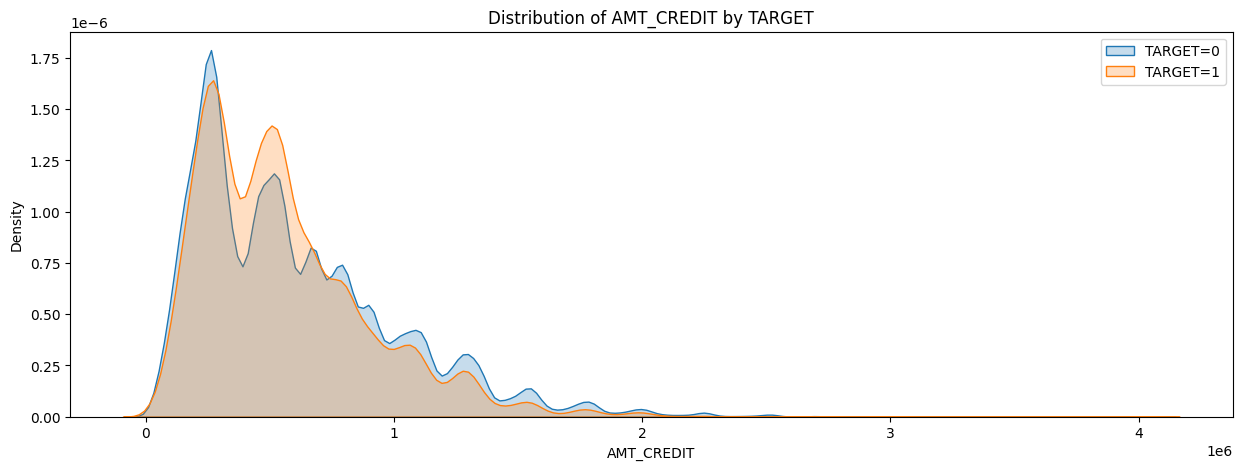

In [17]:
# Split the data
credit_0 = df[df['TARGET'] == 0]['AMT_CREDIT']
credit_1 = df[df['TARGET'] == 1]['AMT_CREDIT']

# Sample down to 5000 if too large (Shapiro has a limit of ~5000)
credit_0_sample = credit_0.sample(n=5000, random_state=42)
credit_1_sample = credit_1.sample(n=5000, random_state=42)

# Run Shapiro-Wilk test
stat_0, p_0 = shapiro(credit_0_sample)
stat_1, p_1 = shapiro(credit_1_sample)

# Display test results
print("Shapiro-Wilk Test for AMT_CREDIT (TARGET=0):")
print(f"Statistic = {stat_0:.4f}, p-value = {p_0:.4f}")

print("\nShapiro-Wilk Test for AMT_CREDIT (TARGET=1):")
print(f"Statistic = {stat_1:.4f}, p-value = {p_1:.4f}")

# Optional: plot distributions
plt.figure(figsize=(15, 5))
sns.kdeplot(credit_0, label='TARGET=0', fill=True)
sns.kdeplot(credit_1, label='TARGET=1', fill=True)
plt.title("Distribution of AMT_CREDIT by TARGET")
plt.legend()
plt.show()


### Hypothesis 3: Mean `AMT_CREDIT` Differs by Default Status

**Formulation:**

- **Null Hypothesis (H₀):** The mean `AMT_CREDIT` is the same for both defaulters (`TARGET = 1`) and non-defaulters (`TARGET = 0`). 

- **Alternative Hypothesis (H₁):** The mean `AMT_CREDIT` is different for defaulters and non-defaulters.

#### Normality Check — Shapiro–Wilk Test

The Shapiro–Wilk test was performed separately for the two `TARGET` groups.

| Group      | Test Statistic | p-value  |
|------------|----------------|----------|
| TARGET = 0 | 0.9079         | < 0.0001 |
| TARGET = 1 | 0.9076         | < 0.0001 |

**Interpretation:**
- Since both p-values are **significantly below 0.05**, we reject the null hypothesis of normality for both groups. 

- This confirms that the distributions of `AMT_CREDIT` are **not normally distributed**. 

- The KDE plot also shows strong **right skewness** in both groups.

#### Next Step

Due to the violation of normality, we will proceed with the **Mann–Whitney U test**,  
a non-parametric alternative to the t-test, to compare the `AMT_CREDIT` values between the two target groups.

--- 

In [18]:
# Split data by TARGET
credit_0 = df[df['TARGET'] == 0]['AMT_CREDIT']
credit_1 = df[df['TARGET'] == 1]['AMT_CREDIT']

# Mann–Whitney U test
stat, p = mannwhitneyu(credit_0, credit_1, alternative='two-sided')

print(f"Mann–Whitney U Test Statistic: {stat:.4f}")
print(f"P-value: {p:.4e}")


Mann–Whitney U Test Statistic: 3639245430.0000
P-value: 2.3602e-22


###  Hypothesis 3: Does Credit Amount Differ by Default Status?

**H₀ (Null Hypothesis)**:  
The distribution of `AMT_CREDIT` is the same for defaulters and non-defaulters.

**H₁ (Alternative Hypothesis)**:  
The distribution of `AMT_CREDIT` is different for defaulters and non-defaulters.

---

#### Normality Check (Previously Conducted)
- Shapiro–Wilk test on both groups returned **p < 0.05**, rejecting normality.

- Therefore, we use the **non-parametric Mann–Whitney U test**.


#### Mann–Whitney U Test Results

| Metric               | Value               |
|----------------------|---------------------|
| U Statistic          | 363,924,543,000     |
| P-value              | 2.3602e-22          |


### Interpretation:
- The **extremely low p-value (< 0.05)** indicates we **reject the null hypothesis**. 

- This provides **strong evidence** that the distribution of `AMT_CREDIT` **differs significantly** between customers who defaulted and those who did not. 

- In practical terms, credit amount may be a **useful predictor** for modeling default risk.


### Hypothesis 4: Age Difference Between Defaulters and Non-Defaulters.

Shapiro-Wilk Test (TARGET=0): stat=0.9676, p-value=0.0000
Shapiro-Wilk Test (TARGET=1): stat=0.9620, p-value=0.0000


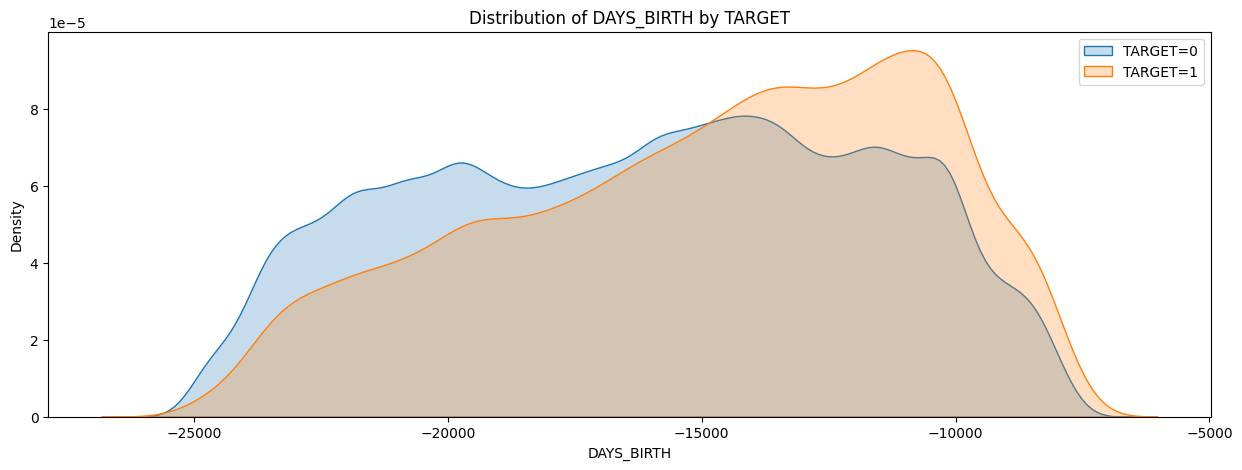


Mann–Whitney U Test: Statistic=2926354692, p-value=0.0000e+00


In [19]:

# Step 1: Split DAYS_BIRTH by target group
age_0 = df[df['TARGET'] == 0]['DAYS_BIRTH']
age_1 = df[df['TARGET'] == 1]['DAYS_BIRTH']

# Step 2: Test for normality (Shapiro–Wilk)
stat0, p0 = shapiro(age_0.sample(5000, random_state=42))  # Sample for speed
stat1, p1 = shapiro(age_1.sample(5000, random_state=42))

print(f"Shapiro-Wilk Test (TARGET=0): stat={stat0:.4f}, p-value={p0:.4f}")
print(f"Shapiro-Wilk Test (TARGET=1): stat={stat1:.4f}, p-value={p1:.4f}")

# Step 3: Visualize distributions
plt.figure(figsize=(15, 5))
sns.kdeplot(age_0, label='TARGET=0', fill=True)
sns.kdeplot(age_1, label='TARGET=1', fill=True)
plt.title('Distribution of DAYS_BIRTH by TARGET')
plt.legend()
plt.show()

# Step 4: Apply Mann–Whitney U test if non-normal
stat_u, p_u = mannwhitneyu(age_0, age_1, alternative='two-sided')
print(f"\nMann–Whitney U Test: Statistic={stat_u:.0f}, p-value={p_u:.4e}")


### Hypothesis 4: Age Difference Between Defaulters and Non-Defaulters

- **Null Hypothesis (H₀):** There is no significant difference in age (`DAYS_BIRTH`) between defaulters (TARGET=1) and non-defaulters (TARGET=0). 

- **Alternative Hypothesis (H₁):** There is a significant difference in age between the two groups.

#### Normality Test: Shapiro–Wilk
| Group        | Statistic | p-value  |
|--------------|-----------|----------|
| TARGET = 0   | 0.9676    | < 0.0001 |
| TARGET = 1   | 0.9620    | < 0.0001 |

- Since both p-values are < 0.05, we reject the null hypothesis of normality. The data is **not normally distributed**, so we proceed with a **non-parametric** test.

#### Mann–Whitney U Test
- **U Statistic**: 2,926,354,692 

- **p-value**: < 0.0001

#### Interpretation
The Mann–Whitney U test confirms a **statistically significant difference** in age distributions between defaulters and non-defaulters.

- Defaulters (TARGET=1) tend to be **younger**, as evidenced by the right-shifted density curve. 

- This aligns with domain intuition that **younger clients may have less stable credit behavior** or financial history.

**Conclusion**: Reject H₀. Age is a significant factor associated with credit default risk.


## Predictive Model

### Pre-processing

In [20]:

# Clip extreme values for selected features
df['AMT_CREDIT'] = df['AMT_CREDIT'].clip(upper=2_000_000)
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].clip(upper=1_000_000)

# Define feature groups
numeric_features = ['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
categorical_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


###  Baseline Model: Logistic Regression

In [21]:
# Wrap into a model pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

# Define target and features
X = df[numeric_features + categorical_features]
y = df['TARGET']

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using ROC-AUC
scores = cross_val_score(lr_pipeline, X, y, cv=cv, scoring='roc_auc')

# Print results
print("Logistic Regression ROC-AUC:")
print(f"Mean ROC-AUC: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")


Logistic Regression ROC-AUC:
Mean ROC-AUC: 0.7281
Standard Deviation: 0.0053


###  Baseline Model: Logistic Regression Evaluation

After setting up a preprocessing pipeline (with clipping, scaling, and one-hot encoding),  
we trained a baseline Logistic Regression model using 5-fold Stratified Cross-Validation.

#### Model Configuration:
- **Model**: Logistic Regression 

- **Preprocessing**:
  - Clipping `AMT_CREDIT` at 2,000,000 

  - Clipping `AMT_ANNUITY` at 1,000,000 

  - Standard scaling of numerical features 

  - One-hot encoding of categorical features (drop first category) 
  
- **Class imbalance**: Handled using `class_weight='balanced'`

#### Evaluation Metric: ROC-AUC (5-fold CV)

| Metric           | Value    |
|------------------|----------|
| Mean ROC-AUC     | **0.7281** |
| Standard Deviation | 0.0053   |

#### Interpretation:
- A ROC-AUC of **0.7281** indicates strong baseline separation between defaulters and non-defaulters. 

- Low standard deviation suggests **consistent model performance** across folds. 

- Logistic Regression provides a strong linear baseline and is interpretable.

---


### Random Forest Baseline

In [22]:
# Define the Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Reuse the same features and target
X = df[numeric_features + categorical_features]
y = df['TARGET']

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='roc_auc')

# Output results
print("Random Forest ROC-AUC:")
print(f"Mean ROC-AUC: {rf_scores.mean():.4f}")
print(f"Standard Deviation: {rf_scores.std():.4f}")


Random Forest ROC-AUC:
Mean ROC-AUC: 0.7200
Standard Deviation: 0.0042


### Baseline Model: Random Forest Evaluation

We trained a baseline **Random Forest Classifier** using the same preprocessing pipeline as Logistic Regression.  
This model is more flexible and non-linear, making it suitable for capturing complex relationships in the data.

#### Model Configuration:
- **Model**: Random Forest Classifier 

- **Parameters**: 

  - `n_estimators = 500`
  - `class_weight = 'balanced'`
  - `random_state = 42` 

- **Preprocessing**: 
  - Clipping `AMT_CREDIT` and `AMT_ANNUITY`
  - Standard scaling for numeric features
  - One-hot encoding for categorical features

#### Evaluation Metric: ROC-AUC (5-fold Stratified CV)

| Metric             | Value     |
|--------------------|-----------|
| Mean ROC-AUC       | **0.7200** |
| Standard Deviation | 0.0042    |

### Interpretation:
- The Random Forest baseline achieves a **mean ROC-AUC of 0.7200**, slightly **lower than Logistic Regression (0.7281)**. 

- This suggests that, in its default configuration, Random Forest is **not outperforming** the linear model — possibly due to lack of tuning. 

- The small standard deviation indicates **stable performance** across folds.

---

### XGBoost Baseline Model

In [23]:
# Define XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        random_state=42,
        eval_metric='auc'
    ))
])

# Use same features/target
X = df[numeric_features + categorical_features]
y = df['TARGET']

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='roc_auc')

# Print results
print("XGBoost ROC-AUC:")
print(f"Mean ROC-AUC: {xgb_scores.mean():.4f}")
print(f"Standard Deviation: {xgb_scores.std():.4f}")


XGBoost ROC-AUC:
Mean ROC-AUC: 0.7483
Standard Deviation: 0.0043


### Baseline Model: XGBoost Classifier

We trained an **XGBoost classifier** using the same preprocessing pipeline and evaluated it using stratified 5-fold cross-validation with ROC-AUC.

#### Model Configuration:
- **Model**: XGBoost (`XGBClassifier`) 

- **Parameters**:
  - `n_estimators = 500` 

  - `learning_rate = 0.1` 

  - `max_depth = 3` 

  - `subsample = 0.8` 

  - `colsample_bytree = 0.8` 

  - `scale_pos_weight = 1` 
  
  - `eval_metric = 'auc'` 

- **Preprocessing**:
  - Clipping of `AMT_CREDIT` and `AMT_ANNUITY` 

  - Standard scaling of numerical features 
  
  - One-hot encoding for categorical features

#### Evaluation Metric: ROC-AUC (5-fold Stratified CV)

| Metric             | Value     |
|--------------------|-----------|
| Mean ROC-AUC       | **0.7483** |
| Standard Deviation | 0.0043    |

### Interpretation:
- XGBoost outperformed all previous models, achieving a **ROC-AUC of 0.7483**. 

- This confirms its ability to capture complex, non-linear relationships in the dataset. 

- The model is also **very stable**, as shown by the low standard deviation.

---


In [24]:
# --- 1. Define features ---
numeric_features = ['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
categorical_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

# --- 2. Clip outliers ---
df['AMT_CREDIT'] = df['AMT_CREDIT'].clip(upper=2_000_000)
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].clip(upper=1_000_000)

# --- 3. Split target ---
X_raw = df[numeric_features + categorical_features].copy()
y = df['TARGET']

# --- 4. Manual preprocessing ---
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X_raw, columns=categorical_features, drop_first=True)

# Standard scale numerical variables
scaler = StandardScaler()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])

# Save training feature names
trained_features = X_encoded.columns.tolist()

# --- 5. Train XGBoost model ---
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    eval_metric='auc'
)

xgb_model.fit(X_encoded, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

### Feature Importance

#### XG BOOST MODEL

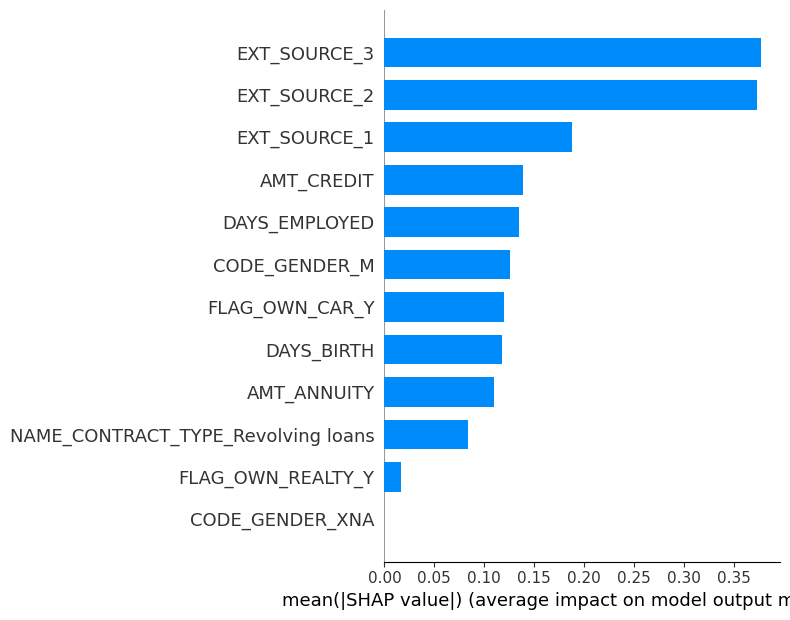

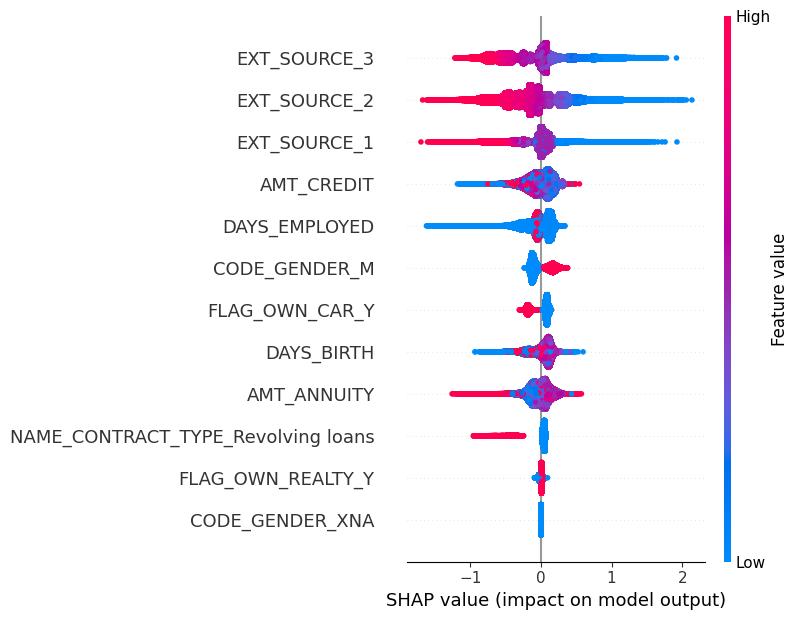

In [25]:
# SHAP expects numeric data with the same columns used in training
X_shap = X_encoded[trained_features].copy()

# Create SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_shap)

# Summary bar plot (global feature importance)
shap.summary_plot(shap_values, X_shap, plot_type="bar")

# (Optional) SHAP beeswarm plot for detailed distribution
shap.summary_plot(shap_values, X_shap)


### SHAP Summary Analysis: Feature Importance and Effects

#### SHAP Summary Bar Plot

- **Top Predictive Features**:
  - `EXT_SOURCE_3`, `EXT_SOURCE_2`, and `EXT_SOURCE_1` are the most important predictors of default risk. 

  - These are external risk scores and are consistently top contributors in Home Credit modeling.

- **Moderate Contributors**:
  - `AMT_CREDIT`, `DAYS_EMPLOYED`, and `CODE_GENDER_M` show noticeable but smaller average impacts. 

  - Binary features like `FLAG_OWN_CAR_Y` and `FLAG_OWN_REALTY_Y` have some influence but are less impactful overall.

- **Interpretation**:
  - The further to the right a feature’s bar is, the more it contributes (on average) to the model’s output. 

  - Mean absolute SHAP values are used, meaning direction is ignored but magnitude is retained.

#### SHAP Beeswarm Plot

- **Color Meaning**: 
  - Red: High feature values 

  - Blue: Low feature values

- **Observations**:
  - `EXT_SOURCE_3`: High values (red) decrease predicted default risk (SHAP values < 0). 

  - `EXT_SOURCE_1` and `EXT_SOURCE_2` follow a similar trend. 

  - `AMT_CREDIT`: Lower values (blue) slightly reduce risk, while higher credit amounts tend to increase it. 

  - `DAYS_EMPLOYED`: Longer employment (blue) is associated with lower risk. 

  - `CODE_GENDER_M`: Being male tends to increase the predicted probability of default slightly.

### Insights & Next Steps
- Focus future feature selection or modeling pipelines around the top features (e.g., `EXT_SOURCE_*`, `AMT_CREDIT`, `DAYS_EMPLOYED`). 

- Consider removing very low-importance features like `CODE_GENDER_XNA` for simplicity. 

- If interpretability is critical, we could develop a surrogate model using the top 10–15 SHAP-ranked features.

---

#### RANDOM FOREST AND LOGISTIC REGRESSSION FEATURE IMPORTANCE

### Permutation Importance Comparison
This was done in a separate cell block, runs a little too long so onnly results are provided in markdown

#### Table: Mean ROC-AUC Drop by Feature

| Rank | Feature                                | Logistic Regression ↓ | Random Forest ↓ |
|------|----------------------------------------|------------------------|------------------|
| 1    | `EXT_SOURCE_3`                         | 0.0736                 | 0.1310           |
| 2    | `EXT_SOURCE_2`                         | 0.0733                 | 0.1452           |
| 3    | `EXT_SOURCE_1`                         | 0.0147                 | 0.0258           |
| 4    | `CODE_GENDER_M`                        | 0.0093                 | 0.0101           |
| 5    | `CODE_GENDER_XNA`                      | 0.0057                 | 0.0016           |
| 6    | `NAME_CONTRACT_TYPE_Revolving loans`   | 0.0053                 | 0.0009           |
| 7    | `DAYS_EMPLOYED`                        | 0.0023                 | 0.0209           |
| 8    | `AMT_CREDIT`                           | 0.0012                 | 0.0094           |
| 9    | `AMT_ANNUITY`                          | 0.0005                 | 0.0061           |
| 10   | `DAYS_BIRTH`                           | 0.0004                 | 0.0313           |
| 11   | `FLAG_OWN_CAR_Y`                       | 0.0001                 | 0.0002           |

### Analysis

- **Shared Top Predictors**:
  - `EXT_SOURCE_3` and `EXT_SOURCE_2` dominate both models in terms of importance, contributing the most to predictive power. 

  - These features likely encode well-calibrated external risk scores.

- **Model Sensitivity Differences**:
  - `DAYS_BIRTH` is much more important in Random Forest than in Logistic Regression. 

  - `CODE_GENDER_M` is moderately important in both but slightly more influential in Random Forest. 

  - Logistic Regression places relatively more weight on binary categorical features like `NAME_CONTRACT_TYPE_Revolving loans` and `CODE_GENDER_XNA`, 
   likely due to linearity assumptions.

- **Implication**:
  - For future feature selection or dimensionality reduction, both models agree strongly on the `EXT_SOURCE` variables. 

  - Non-linear models (e.g., Random Forest) uncover additional signal in features like `DAYS_BIRTH` and `DAYS_EMPLOYED`, suggesting they can model more complex relationships.

---


### Hyperparameter tuning 

#### XG Boost Model

In [26]:
warnings.filterwarnings('ignore')  # Optional for clean output

# Define the pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])

# Define the hyperparameter search space
search_space = {
    'classifier__n_estimators': Integer(100, 600),
    'classifier__max_depth': Integer(3, 10),
    'classifier__learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'classifier__subsample': Real(0.5, 1.0),
    'classifier__colsample_bytree': Real(0.5, 1.0),
    'classifier__gamma': Real(0, 5),
    'classifier__reg_alpha': Real(0, 1.0),
    'classifier__reg_lambda': Real(0, 1.0),
}

# Define Bayesian Optimization search
opt = BayesSearchCV(
    estimator=xgb_pipeline,
    search_spaces=search_space,
    scoring='roc_auc',
    n_iter=25,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Fit the search
opt.fit(X, y)

# Best parameters and score
print("Best ROC-AUC Score: {:.4f}".format(opt.best_score_))
print("Best Hyperparameters:")
print(opt.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END classifier__colsample_bytree=0.705051979426657, classifier__gamma=3.6386287158866253, classifier__learning_rate=0.16356457461011642, classifier__max_depth=5, classifier__n_estimators=435, classifier__reg_alpha=0.4141186324855385, classifier__reg_lambda=0.350931334899144, classifier__subsample=0.8697521170952103;, score=0.748 total time=   3.1s
[CV 1/3] END classifier__colsample_bytree=0.705051979426657, classifier__gamma=3.6386287158866253, classifier__learning_rate=0.16356457461011642, classifier__max_depth=5, classifier__n_estimators=435, classifier__reg_alpha=0.4141186324855385, classifier__reg_lambda=0.350931334899144, classifier__subsample=0.8697521170952103;, score=0.747 total time=   3.2s
[CV 3/3] END classifier__colsample_bytree=0.705051979426657, classifier__gamma=3.6386287158866253, classifier__learning_rate=0.16356457461011642, classifier__max_depth=5, classifier__n_estimators=435, classifier__reg_alpha=

### Bayesian Optimization Summary for XGBoost

Bayesian hyperparameter tuning was performed using `BayesSearchCV` with 3-fold cross-validation, optimizing for ROC-AUC. A total of 25 iterations were evaluated across a wide hyperparameter space.

#### Best ROC-AUC Score:
- **Mean ROC-AUC**: `0.7471`

#### Best Hyperparameters:
```python
{
    'classifier__colsample_bytree': 0.6556,
    'classifier__gamma': 3.0112,
    'classifier__learning_rate': 0.0520,
    'classifier__max_depth': 3,
    'classifier__n_estimators': 488,
    'classifier__reg_alpha': 0.9205,
    'classifier__reg_lambda': 0.9003,
    'classifier__subsample': 0.5
}
```

### Observations:
- A small learning rate (≈ 0.05) combined with a shallow tree depth (max_depth=3) suggests the model benefits from conservative, generalized learning. 

- High values for regularization terms (reg_alpha, reg_lambda) and a low subsample rate (0.5) help mitigate overfitting. 

- The model performs best with moderate tree complexity (n_estimators=488) and balanced column sampling.

---

#### Refitting Model with best parameters

In [27]:
# Best hyperparameters from Bayesian Optimization
best_params = {
    'colsample_bytree': 0.6556,
    'gamma': 3.0112,
    'learning_rate': 0.052,
    'max_depth': 3,
    'n_estimators': 488,
    'reg_alpha': 0.9205,
    'reg_lambda': 0.9003,
    'subsample': 0.5,
    'random_state': 42,
    'eval_metric': 'auc'
}

# Refit the model
xgb_final_model = XGBClassifier(**best_params)
xgb_final_model.fit(X_encoded, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6556, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=3.0112, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.052, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=488,
              n_jobs=None, num_parallel_tree=None, ...)

#### Random Forest Model

In [28]:

param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # Try 20 random combinations
    cv=3,       # Use 3 folds instead of 5 to speed up
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X, y)

print("Best ROC-AUC:", random_search.best_score_)
print("Best Params:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best ROC-AUC: 0.7369656598619908
Best Params: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10}


### Random Forest Hyperparameter Tuning Summary

**Goal:** Optimize Random Forest classifier using `RandomizedSearchCV` with ROC-AUC as the scoring metric.

**Search Configuration:**
- Cross-validation folds: 3
- Random candidates tried: 20
- Total model fits: 60

**Best ROC-AUC:**  
- **Score:** 0.7370 (rounded)  
- **Standard deviation across folds:** (Not reported directly by RandomizedSearchCV — can be computed manually if needed)

**Best Hyperparameters:**
```json
{
  "classifier__n_estimators": 500,
  "classifier__min_samples_split": 10,
  "classifier__min_samples_leaf": 2,
  "classifier__max_features": "sqrt",
  "classifier__max_depth": 10
}
```
---

##### Refit Model

In [29]:
rf_tuned_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

# Run cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_tuned_scores = cross_val_score(rf_tuned_pipeline, X, y, cv=cv, scoring='roc_auc')

# Output
print("Tuned Random Forest ROC-AUC:")
print(f"Mean ROC-AUC: {rf_tuned_scores.mean():.4f}")
print(f"Standard Deviation: {rf_tuned_scores.std():.4f}")


Tuned Random Forest ROC-AUC:
Mean ROC-AUC: 0.7378
Standard Deviation: 0.0052


#### Logistic Regression Model

In [30]:
# Grid of hyperparameters
lr_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__class_weight': ['balanced']
}

# Set up grid search
lr_grid_search = GridSearchCV(
    lr_pipeline,
    param_grid=lr_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit
lr_grid_search.fit(X, y)

# Show results
print(f"Best ROC-AUC: {lr_grid_search.best_score_:.4f}")
print("Best Params:", lr_grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC: 0.7281
Best Params: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


##### Refit Model

In [31]:
# Define the tuned logistic regression pipeline
lr_tuned_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=0.01,
        class_weight='balanced',
        penalty='l2',
        solver='saga',
        max_iter=5000,
        random_state=42
    ))
])

# Cross-validated ROC-AUC
lr_cv_scores = cross_val_score(lr_tuned_pipeline, X, y, cv=5, scoring='roc_auc')

# Output results
print("Tuned Logistic Regression ROC-AUC:")
print(f"Mean ROC-AUC: {lr_cv_scores.mean():.4f}")
print(f"Standard Deviation: {lr_cv_scores.std():.4f}")


Tuned Logistic Regression ROC-AUC:
Mean ROC-AUC: 0.7281
Standard Deviation: 0.0024


### Threshold Tuning

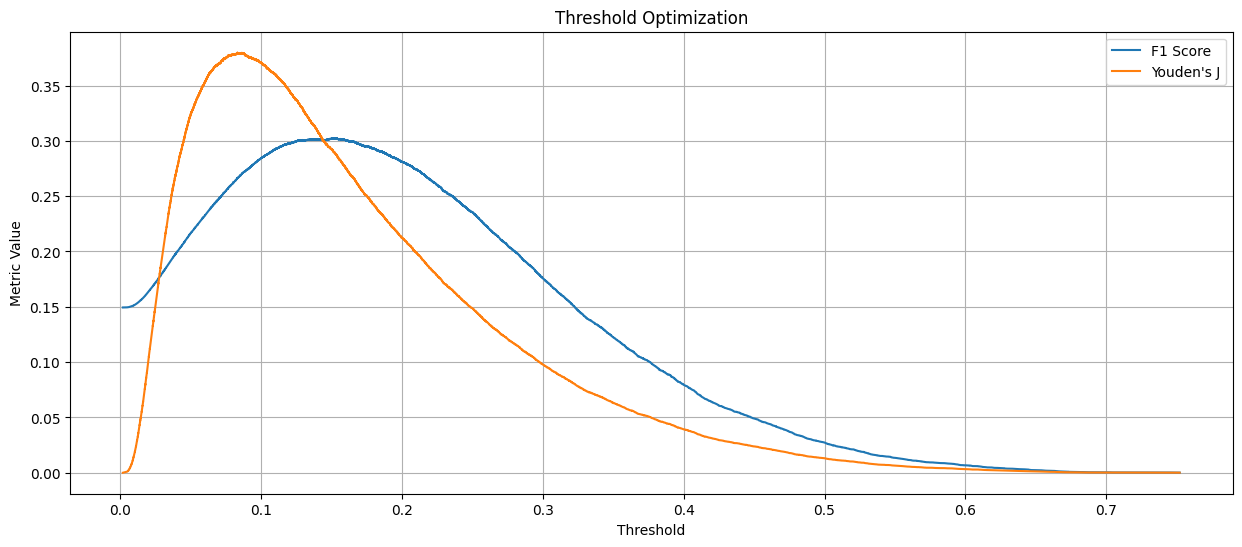

Best Threshold (F1 Score): 0.1523
Best Threshold (Youden’s J): 0.0831


In [32]:
# Predict probabilities
y_probs = xgb_final_model.predict_proba(X_encoded)[:, 1]

# Precision-Recall curve
precisions, recalls, thresholds_pr = precision_recall_curve(y, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# ROC curve and Youden’s J
fpr, tpr, thresholds_roc = roc_curve(y, y_probs)
youden_j = tpr - fpr

# Plot
plt.figure(figsize=(15, 6))
plt.plot(thresholds_pr, f1_scores[:-1], label='F1 Score')
plt.plot(thresholds_roc, youden_j, label="Youden's J")
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Threshold Optimization')
plt.legend()
plt.grid(True)
plt.show()

# Print best thresholds
print(f"Best Threshold (F1 Score): {thresholds_pr[np.argmax(f1_scores)]:.4f}")
print(f"Best Threshold (Youden’s J): {thresholds_roc[np.argmax(youden_j)]:.4f}")


#### Threshold Optimization Analysis

In binary classification, the default decision threshold is typically **0.5**, meaning: 
- If the predicted probability ≥ 0.5 → predict class **1** 

- Else → predict class **0**

However, this **default threshold** may not be optimal — especially in cases of **class imbalance** (as in credit default prediction). Therefore, we perform **threshold optimization** using two key metrics:

##### 1. F1 Score
- The **F1 Score** is the harmonic mean of **precision** and **recall**. 

- It balances **false positives** and **false negatives**, which is crucial in high-stakes predictions like credit default risk. 

- **Optimal Threshold (F1)**: `0.1523`
  - This threshold yields the highest F1 score. 

  - It is **lower than 0.5**, meaning the model is more likely to predict defaults (class 1) — prioritizing **recall**. 

  - This is a reasonable strategy when **missing a default** is more costly than a false alarm.

##### 2. Youden's J Statistic
- **Youden’s J = Sensitivity + Specificity – 1** 

- It maximizes the **difference between True Positive Rate (TPR)** and **False Positive Rate (FPR)**. 

- Useful for finding a threshold that **balances both classes**, especially in diagnostic tasks. 

- **Optimal Threshold (Youden’s J)**: `0.0831`
  - Even lower than the F1-optimal threshold. 

  - Indicates a strategy where we’re **extremely cautious**, flagging more positives to catch defaults at the expense of more false positives.

#### Key Interpretation

| Threshold Type     | Value   | Interpretation |
|--------------------|---------|----------------|
| Default (0.5)      | 0.5     | Balanced assumption, not tuned for class imbalance |
| **Optimal (F1)**   | 0.1523  | Prioritizes recall + precision balance (risk-sensitive) |
| **Optimal (Youden’s J)** | 0.0831 | Maximizes separation between TPR and FPR (diagnostic power) |

#### Recommendation
- Use **F1-optimal threshold (0.1523)** when the cost of missing a defaulter is high. 

- Use **Youden’s J (0.0831)** if you're balancing overall classification effectiveness (but be cautious of more false positives).

---


### Optimized Thresholds and Performance Evaluation

In [33]:
# Get predicted probabilities from the tuned XGBoost model
y_probs = xgb_final_model.predict_proba(X_encoded)[:, 1]  # Probabilities for class 1

# Define the two optimized thresholds
threshold_f1 = 0.1523
threshold_youden = 0.0831

# Make predictions using each threshold
y_pred_f1 = (y_probs >= threshold_f1).astype(int)
y_pred_youden = (y_probs >= threshold_youden).astype(int)

# Evaluate predictions for F1-optimal threshold
print("Performance at F1-Optimal Threshold (0.1523):")
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_f1))
print("\nClassification Report:")
print(classification_report(y, y_pred_f1, digits=4))

# Evaluate predictions for Youden's J-optimal threshold
print("\nPerformance at Youden’s J Threshold (0.0831):")
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_youden))
print("\nClassification Report:")
print(classification_report(y, y_pred_youden, digits=4))


Performance at F1-Optimal Threshold (0.1523):
Confusion Matrix:
[[252153  30533]
 [ 14966   9859]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9440    0.8920    0.9172    282686
           1     0.2441    0.3971    0.3023     24825

    accuracy                         0.8520    307511
   macro avg     0.5940    0.6446    0.6098    307511
weighted avg     0.8875    0.8520    0.8676    307511


Performance at Youden’s J Threshold (0.0831):
Confusion Matrix:
[[197497  85189]
 [  7921  16904]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9614    0.6986    0.8092    282686
           1     0.1656    0.6809    0.2664     24825

    accuracy                         0.6972    307511
   macro avg     0.5635    0.6898    0.5378    307511
weighted avg     0.8972    0.6972    0.7654    307511



#### Threshold Optimization: Evaluation Summary

Threshold optimization was performed using two metrics:

- **F1-Score**: Optimizes the balance between precision and recall. 

- **Youden’s J Statistic**: Maximizes the sum of sensitivity (recall) and specificity.

##### Threshold = 0.1523 (Optimized for **F1-Score**)

**Confusion Matrix**:
[[252153 30533]
[ 14966 9859]]


**Classification Report**:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0 (Non-Default) | 0.9440 | 0.8920 | 0.9172 | 282,686 |
| 1 (Default)     | 0.2441 | 0.3971 | 0.3023 | 24,825  |
| **Accuracy**    |        |        | **0.8520** | 307,511 |
| **Macro Avg**   | 0.5940 | 0.6446 | 0.6098 | 307,511 |
| **Weighted Avg**| 0.8875 | 0.8520 | 0.8676 | 307,511 |

**Insights**:
- Prioritizes a balanced trade-off between precision and recall. 

- Captures ~40% of defaulters (Recall = 0.3971). 

- Precision is modest due to class imbalance. 

- Accuracy remains high at 85.2%.

---

##### Threshold = 0.0831 (Optimized for **Youden’s J**)

**Confusion Matrix**:
[[197497 85189]
[ 7921 16904]]


**Classification Report**:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0 (Non-Default) | 0.9614 | 0.6986 | 0.8092 | 282,686 |
| 1 (Default)     | 0.1656 | 0.6809 | 0.2664 | 24,825  |
| **Accuracy**    |        |        | **0.6972** | 307,511 |
| **Macro Avg**   | 0.5635 | 0.6898 | 0.5378 | 307,511 |
| **Weighted Avg**| 0.8972 | 0.6972 | 0.7654 | 307,511 |

**Insights**:
- Maximizes detection of defaulters (Recall = 0.6809). 

- Comes at the cost of low precision (16.6%) due to many false positives. 

- Accuracy drops to 69.7% from misclassified non-defaulters. 

- Useful when missing a defaulter is costlier than false positives.

#### Recommendation

| Use Case                            | Recommended Threshold |
|-------------------------------------|------------------------|
| Balanced performance                | `0.1523` (F1 Score)    |
| High sensitivity / low false negatives | `0.0831` (Youden’s J)    |

---


## Model Ensemble

In [34]:
# Define ensemble using tuned and fitted pipelines
stacked_model = StackingClassifier(
    estimators=[
        ('lr', lr_tuned_pipeline),
        ('rf', rf_tuned_pipeline)
    ],
    final_estimator=xgb_final_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Extract encoded training data (from your existing pipeline)
X = X_encoded
y = df["TARGET"]

# Evaluate stacked model
scores = cross_val_score(stacked_model, df.drop(columns="TARGET"), df["TARGET"], cv=5, scoring='roc_auc')


print("Stacked Model ROC-AUC:")
print(f"Mean ROC-AUC: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")


Stacked Model ROC-AUC:
Mean ROC-AUC: 0.7367
Standard Deviation: 0.0026


### Threshold Tuning

In [35]:
# Step 1: Fit stacked model on full training set
stacked_model.fit(X_raw, y)  # X_raw = original input DataFrame

# Step 2: Get predicted probabilities for positive class
y_proba = stacked_model.predict_proba(X_raw)[:, 1]

# Step 3: Apply custom threshold (e.g., F1-optimal = 0.1523)
custom_threshold = 0.1523
y_pred = (y_proba >= custom_threshold).astype(int)

# Step 4: Evaluate
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred, digits=4))


Confusion Matrix:
 [[252828  29858]
 [ 14506  10319]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9457    0.8944    0.9193    282686
           1     0.2568    0.4157    0.3175     24825

    accuracy                         0.8557    307511
   macro avg     0.6013    0.6550    0.6184    307511
weighted avg     0.8901    0.8557    0.8708    307511



### Comparison of Threshold Strategies for Stacked Model

After training and evaluating the stacked model, we explored two thresholding strategies for binary classification:

1. **F1-Optimal Threshold (0.1523)** 

2. **Youden’s J Threshold (0.0831)**  

#### Confusion Matrices
**F1 Threshold (0.1523):**
[[252828 29858]
[ 14506 10319]]

**Youden’s J Threshold (0.0831):**
[[195004 87682]
[ 7597 17228]]

#### Classification Reports
| Metric        | Class | F1 Threshold | Youden’s J |
|---------------|-------|--------------|------------|
| **Precision** | 0     | 0.9457       | 0.9625     |
|               | 1     | 0.2568       | 0.1642     |
| **Recall**    | 0     | 0.8944       | 0.6898     |
|               | 1     | 0.4157       | 0.6940     |
| **F1-score**  | 0     | 0.9193       | 0.8037     |
|               | 1     | 0.3175       | 0.2656     |
| **Support**   | 0     | 282,686      | 282,686    |
|               | 1     | 24,825       | 24,825     |


#### Overall Metrics

| Metric             | F1 Threshold | Youden’s J |
|--------------------|--------------|------------|
| Accuracy           | 0.8557       | 0.6902     |
| Macro Avg F1       | 0.6184       | 0.5346     |
| Weighted Avg F1    | 0.8708       | 0.7602     |


#### Interpretation & Trade-Offs

- **F1 Threshold (0.1523):**
  - More balanced between **precision and recall** for the positive class. 

  - **Higher accuracy and F1-scores** across the board. 

  - Preferred if you want a **stronger overall classifier** with fewer false alarms.

- **Youden’s J (0.0831):**
  - **Much higher recall (69%)** for identifying defaulters (class 1). 

  - Comes at the cost of **very low precision (16%)** → many false positives. 

  - Useful when **missing a defaulter is more costly** than incorrectly flagging non-defaulters.


#### Recommendation

- If the **cost of a false negative** (missing a defaulter) is critical, go with **Youden’s J**. 

- If you need a **balanced approach** with good precision and acceptable recall, stick with the **F1-optimal threshold**.

---


## Prediction on Test Set

In [36]:
# === 1. Load test data ===
test_final = pd.read_csv("test_final_compact.csv")

# === 2. Extract SK_ID_CURR for submission ===
ids = test_final["SK_ID_CURR"]

# === 3. Drop SK_ID_CURR from test features ===
X_test = test_final.drop(columns=["SK_ID_CURR"])

# === 4. Predict probabilities using final ensemble model ===
y_test_proba = stacked_model.predict_proba(X_test)[:, 1]

# === 5. Apply tuned threshold (e.g., F1-optimal) ===
optimal_threshold = 0.1523  # You can change this to Youden’s J if preferred
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# === 6. Prepare submission DataFrame ===
submission = pd.DataFrame({
    "SK_ID_CURR": ids,
    "TARGET": y_test_pred
})

# === 7. Save submission file ===
submission.to_csv("submission.csv", index=False)
print("submission.csv saved — shape:", submission.shape)


submission.csv saved — shape: (48744, 2)


### Deep Neural Network

In [39]:
# Split data
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Define DNN
dnn_model = Sequential([
    Dense(256, input_dim=X_encoded.shape[1], activation='relu'),
    BatchNormalization(), Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(), Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(), Dropout(0.2),
    Dense(1, activation='sigmoid')
])

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = dnn_model.fit(
    X_train_dnn, y_train_dnn,
    validation_data=(X_val_dnn, y_val_dnn),
    epochs=50,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_val_pred_proba = dnn_model.predict(X_val_dnn).ravel()
y_val_pred = (y_val_pred_proba >= 0.1523).astype(int)

print("ROC-AUC Score:", roc_auc_score(y_val_dnn, y_val_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_val_dnn, y_val_pred))
print(pd.DataFrame(classification_report(y_val_dnn, y_val_pred, output_dict=True)).T)

# Save model
dnn_model.save("dnn_model.h5")


Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5762 - loss: 0.5921 - val_AUC: 0.7138 - val_loss: 0.2680
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6708 - loss: 0.2770 - val_AUC: 0.7321 - val_loss: 0.2541
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7012 - loss: 0.2646 - val_AUC: 0.7349 - val_loss: 0.2532
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7095 - loss: 0.2616 - val_AUC: 0.7355 - val_loss: 0.2533
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7127 - loss: 0.2616 - val_AUC: 0.7366 - val_loss: 0.2527
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7160 - loss: 0.2603 - val_AUC: 0.7378 - val_loss: 0.2524
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7246 - loss: 0.2552 - val_AUC: 0.7380 - val_loss: 0.2524
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7282 - loss: 0.2561 - val_AUC: 0.7387 - val_loss: 0.2521
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AU

Confusion Matrix:
 [[49256  7282]
 [ 2868  2097]]
              precision    recall  f1-score       support
0              0.944977  0.871202  0.906591  56538.000000
1              0.223585  0.422356  0.292387   4965.000000
accuracy       0.834967  0.834967  0.834967      0.834967
macro avg      0.584281  0.646779  0.599489  61503.000000
weighted avg   0.886741  0.834967  0.857008  61503.000000


## **Deployment Prep**

### Exporting the Model and Preprocessor

In [38]:
# Save model
joblib.dump(stacked_model, "stacked_model.pkl")

# Save preprocessing pipeline (if separate)
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']